In [1]:
try:
    import music21
except:
    !pip install music21
    !sudo apt-get update
    !sudo apt install musescore3 -y

In [2]:
try:
    import midi2audio
except:
    !pip install midi2audio
    !sudo apt-get update
    !sudo apt-get install fluidsynth -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [663 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,346 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,057 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.6 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-secu

--------------------------
# Import Library

In [3]:
import IPython
from IPython.display import Image, Audio
from midi2audio import FluidSynth
from music21 import corpus, converter, instrument, note, stream, chord, duration
import matplotlib.pyplot as plt
from collections import Counter
import time

import os
import pickle
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

import os
import numpy as np
import glob

from keras.layers import LSTM, GRU, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from keras.layers import Multiply, Lambda, Softmax
import keras.backend as K
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import save_model
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--------------------------
**Original music:**

In [5]:
dataset_name = '/content/drive/MyDrive/Final_project/beeth'
filename = 'beethoven_les_adieux_3'
file = "{}/{}.mid".format(dataset_name, filename)

original_score = converter.parse(file).chordify()

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2008 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


**Let's listen to the original first.**

In [6]:
fs = FluidSynth()
file = '/content/drive/MyDrive/Final_project/beeth/beethoven_opus22_2.mid'
fs.midi_to_audio(file, 'beethoven_opus22_2.wav')
IPython.display.Audio("beethoven_opus22_2.wav")

In [ ]:
fs.midi_to_audio('/content/drive/MyDrive/Final_project/beeth/elise.mid', 'elise.wav')
IPython.display.Audio("elise.wav")

In [ ]:
original_score.show()

---------------------
# Extracting the data

In [9]:
notes = []
durations = []

for element in original_score.flat:
    if isinstance(element, chord.Chord):
        notes.append('.'.join(n.nameWithOctave for n in element.pitches))
        durations.append(element.duration.quarterLength)

    if isinstance(element, note.Note):
        if element.isRest:
            notes.append(str(element.name))
            durations.append(element.duration.quarterLength)
        else:
            notes.append(str(element.nameWithOctave))
            durations.append(element.duration.quarterLength)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
notes[:20]

['B-3.D4.F4.G#4.G#5.D6.F6.G#6',
 'B-2.B-3',
 'D3.A3',
 'B-2.B-3',
 'D3.D4',
 'D3.F4',
 'F3.D4',
 'D3.F4',
 'F3.G#4',
 'D3.F4',
 'F3.D4',
 'F3.G#4',
 'G#3.F4',
 'F3.G#4',
 'G#3.B-4',
 'F3.G#4',
 'G#3.F4',
 'B-3.B-4',
 'D4.G#4',
 'B-3.B-4']

In [11]:
count_num = Counter(notes)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 828


In [12]:
print('\nduration', 'pitch')
idx = 0
for n,d in zip(notes,durations):
    if idx < 50:
        print(d, '\t', n)
    idx = idx + 1


duration pitch
0.25 	 B-3.D4.F4.G#4.G#5.D6.F6.G#6
0.25 	 B-2.B-3
0.25 	 D3.A3
0.25 	 B-2.B-3
0.25 	 D3.D4
0.25 	 D3.F4
0.25 	 F3.D4
0.25 	 D3.F4
0.25 	 F3.G#4
0.25 	 D3.F4
0.25 	 F3.D4
0.25 	 F3.G#4
0.25 	 G#3.F4
0.25 	 F3.G#4
0.25 	 G#3.B-4
0.25 	 F3.G#4
0.25 	 G#3.F4
0.25 	 B-3.B-4
0.25 	 D4.G#4
0.25 	 B-3.B-4
0.25 	 D4.D5
0.25 	 B-3.B-4
0.25 	 D4.G#4
0.25 	 D4.F5
0.25 	 F4.D5
0.25 	 D4.F5
0.25 	 F4.G#5
0.25 	 D4.F5
0.25 	 F4.D5
0.25 	 F4.G#5
0.25 	 G#4.F5
0.25 	 F4.G#5
0.25 	 G#4.B-5
0.25 	 F4.G#5
0.25 	 G#4.F5
0.25 	 D5.B-5
0.25 	 F5.G#5
0.25 	 D5.B-5
0.25 	 F5.D6
0.25 	 D5.B-5
0.25 	 F5.G#5
0.25 	 F5.D6
0.25 	 G#5.B-5
0.25 	 F5.D6
0.25 	 G#5.F6
0.25 	 F5.D6
0.25 	 G#5.B-5
0.25 	 F6
0.25 	 D6
0.25 	 F6


<hr style="border: solid 3px blue;">

# Creating Music

## Helper Functions

In [13]:
def get_music_list(data_folder):
    file_list = glob.glob(os.path.join(data_folder, "*.mid"))
    parser = converter
    return file_list, parser

def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))
    return (element_to_int, int_to_element)


def sample_with_temp(preds, temp):
    if temp == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temp
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [14]:
# run params
data_folder = '/content/drive/MyDrive/Final_project/beeth'

mode = 'build'

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [15]:
notes = []
durations = []

if mode == 'build':
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        print(file)
        original_score = parser.parse(file).chordify()
        for interval in intervals:
            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

29 files in total
1 Parsing /content/drive/MyDrive/Final_project/beeth/mond_1.mid
/content/drive/MyDrive/Final_project/beeth/mond_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Mondscheinsonate; der Gr\xe4fin Giulietta Guiccardi gewidmet'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


2 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus22_2.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus22_2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2009 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


3 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus90_1.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus90_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


4 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_hammerklavier_1.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_hammerklavier_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2008 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


5 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_hammerklavier_3.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_hammerklavier_3.mid
6 Parsing /content/drive/MyDrive/Final_project/beeth/appass_1.mid
/content/drive/MyDrive/Final_project/beeth/appass_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


7 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus22_4.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus22_4.mid
8 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus22_3.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus22_3.mid
9 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus90_2.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus90_2.mid
10 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_hammerklavier_2.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_hammerklavier_2.mid
11 Parsing /content/drive/MyDrive/Final_project/beeth/pathetique_2.mid
/content/drive/MyDrive/Final_project/beeth/pathetique_2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 2. Movement'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=7, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


12 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus22_1.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus22_1.mid
13 Parsing /content/drive/MyDrive/Final_project/beeth/appass_2.mid
/content/drive/MyDrive/Final_project/beeth/appass_2.mid
14 Parsing /content/drive/MyDrive/Final_project/beeth/mond_2.mid
/content/drive/MyDrive/Final_project/beeth/mond_2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


15 Parsing /content/drive/MyDrive/Final_project/beeth/appass_3.mid
/content/drive/MyDrive/Final_project/beeth/appass_3.mid
16 Parsing /content/drive/MyDrive/Final_project/beeth/waldstein_2.mid
/content/drive/MyDrive/Final_project/beeth/waldstein_2.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


17 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_les_adieux_3.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_les_adieux_3.mid
18 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_les_adieux_1.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_les_adieux_1.mid
19 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus10_3.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus10_3.mid
20 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_hammerklavier_4.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_hammerklavier_4.mid
21 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_les_adieux_2.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_les_adieux_2.mid
22 Parsing /content/drive/MyDrive/Final_project/beeth/waldstein_1.mid
/content/drive/MyDrive/Final_project/beeth/waldstein_1.mid
23 Parsing /content/drive/MyDrive/Final_project/beeth/pathetique_3.mid
/content/drive/MyDrive/Final_project/beeth/path

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 3. Movement'>; getting generic Instrument
  warnings.warn(


24 Parsing /content/drive/MyDrive/Final_project/beeth/waldstein_3.mid
/content/drive/MyDrive/Final_project/beeth/waldstein_3.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


25 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus10_2.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus10_2.mid
26 Parsing /content/drive/MyDrive/Final_project/beeth/elise.mid
/content/drive/MyDrive/Final_project/beeth/elise.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'F\xfcr Elise'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'Beethoven F\xfcr Elise'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


27 Parsing /content/drive/MyDrive/Final_project/beeth/pathetique_1.mid
/content/drive/MyDrive/Final_project/beeth/pathetique_1.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 1. Movement'>; getting generic Instrument
  warnings.warn(


28 Parsing /content/drive/MyDrive/Final_project/beeth/mond_3.mid
/content/drive/MyDrive/Final_project/beeth/mond_3.mid


/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


29 Parsing /content/drive/MyDrive/Final_project/beeth/beethoven_opus10_1.mid
/content/drive/MyDrive/Final_project/beeth/beethoven_opus10_1.mid


# Data Preprocessing

In [16]:
len(notes)

62291

In [17]:
notes[30:50]

['START',
 'START',
 'C#2.C#3.G#3',
 'C#2.C#3.C#4',
 'C#2.C#3.E4',
 'C#2.C#3.G#3',
 'C#2.C#3.G#3',
 'C#2.C#3.C#4',
 'C#2.C#3.C#4',
 'C#2.C#3.E4',
 'C#2.C#3.E4',
 'C#2.C#3.G#3',
 'C#2.C#3.C#4',
 'C#2.C#3.E4',
 'C#2.C#3.G#3',
 'C#2.C#3.C#4',
 'C#2.C#3.E4',
 'B1.B2.G#3',
 'B1.B2.C#4',
 'B1.B2.E4']

In [18]:
count_num = Counter(notes)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 14816


In [19]:
count_num

Counter({'START': 928,
         'C#2.C#3.G#3': 10,
         'C#2.C#3.C#4': 22,
         'C#2.C#3.E4': 5,
         'B1.B2.G#3': 4,
         'B1.B2.C#4': 5,
         'B1.B2.E4': 4,
         'A1.A2.A3': 6,
         'A1.A2.C#4': 6,
         'A1.A2.E4': 3,
         'F#1.F#2.A3': 4,
         'F#1.F#2.D4': 3,
         'F#1.F#2.F#4': 4,
         'G#1.G#2.G#3': 13,
         'G#1.G#2.C4': 16,
         'G#1.G#2.F#4': 13,
         'G#1.G#2.C#4': 8,
         'G#1.G#2.E4': 10,
         'G#1.G#2.E-4': 14,
         'G#1.G#2.F#3': 7,
         'C#2.G#2.C#3.E3': 3,
         'C#2.G#2.C#3.G#3': 7,
         'C#2.G#2.C#3.C#4': 7,
         'C#2.G#2.C#3.E4': 4,
         'C#2.G#2.C#3.G#3.G#4': 2,
         'C#2.G#2.C#3.C#4.G#4': 2,
         'C#2.G#2.C#3.E4.G#4': 4,
         'C2.G#2.C3.G#3.G#4': 8,
         'C2.G#2.C3.E-4.G#4': 8,
         'C2.G#2.C3.F#4.G#4': 10,
         'C#2.C#3.G#3.G#4': 5,
         'C#2.C#3.C#4.G#4': 5,
         'C#2.C#3.E4.G#4': 7,
         'F#1.F#2.A3.A4': 7,
         'F#1.F#2.C#4.A4': 7,


In [20]:
#Exploring the notes dictionary
Notes_unique = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 4.20430615550756
Most frequent note in Corpus appeared: 928 times
Least frequent note in Corpus appeared: 1 time


In [21]:
len(Notes_unique)

14816

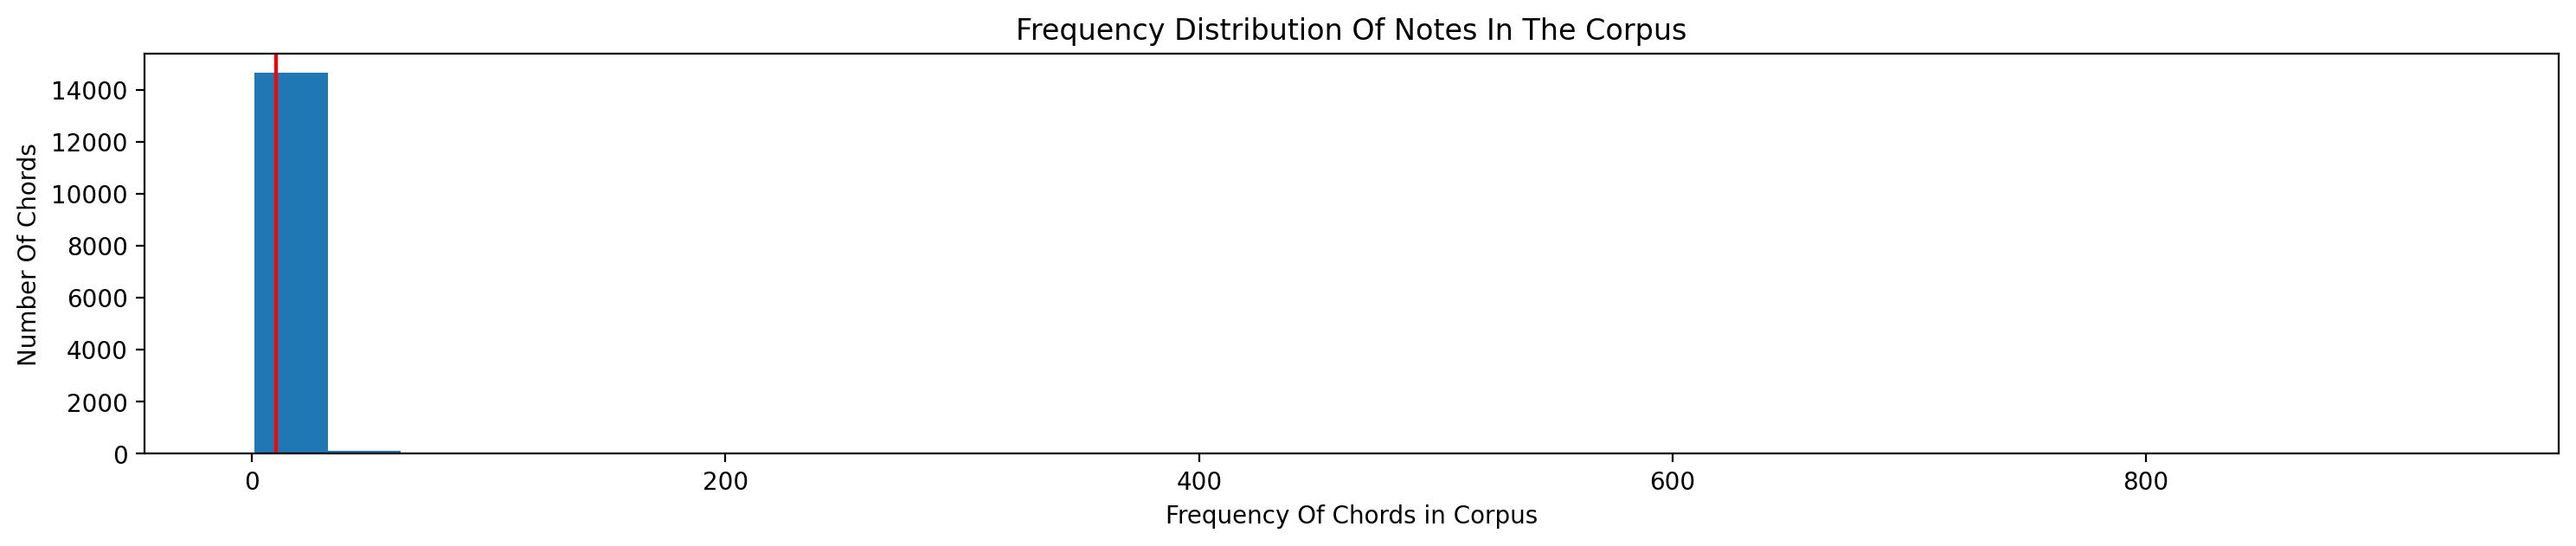

In [22]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3))
bins = 30
plt.hist(Recurrence, bins=bins)
plt.axvline(x=10, color = 'red')
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [23]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 10:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 10 times:", len(rare_note))

Total number of notes that occur less than 10 times: 13781


In [24]:
length = len(notes)
i = 0
while(length > i):
    element = notes[i]
    if element in rare_note:
        notes.pop(i)
        durations.pop(i)
        length -= 1
    else:
        i += 1

print("Length of Corpus after elemination the rare notes:", len(notes))

Length of Corpus after elemination the rare notes: 31327


In [25]:
count_num = Counter(notes)
print("Total unique notes after elemination in the Corpus:", len(count_num))

Total unique notes after elemination in the Corpus: 1035


# Embedding Note and Duration

In [26]:
def prepare_sequences(notes, durations, lookups, distincts, seq_len =32):
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups
    note_names, n_notes, duration_names, n_durations = distincts

    notes_network_input = []
    notes_network_output = []
    durations_network_input = []
    durations_network_output = []

    # create input sequences and the corresponding outputs
    for i in range(len(notes) - seq_len):
        notes_sequence_in = notes[i:i + seq_len]
        notes_sequence_out = notes[i + seq_len]
        notes_network_input.append([note_to_int[char] for char in notes_sequence_in])
        notes_network_output.append(note_to_int[notes_sequence_out])

        durations_sequence_in = durations[i:i + seq_len]
        durations_sequence_out = durations[i + seq_len]
        durations_network_input.append([duration_to_int[char] for char in durations_sequence_in])
        durations_network_output.append(duration_to_int[durations_sequence_out])

    n_patterns = len(notes_network_input)

    # reshape the input into a format compatible with LSTM layers
    notes_network_input = np.reshape(notes_network_input, (n_patterns, seq_len))
    durations_network_input = np.reshape(durations_network_input, (n_patterns, seq_len))
    network_input = [notes_network_input, durations_network_input]

    notes_network_output = keras.utils.to_categorical(notes_network_output, num_classes=n_notes)
    durations_network_output = keras.utils.to_categorical(durations_network_output, num_classes=n_durations)
    network_output = [notes_network_output, durations_network_output]

    return (network_input, network_output)

In [27]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]


In [28]:
n_notes

1035

In [29]:
print('\nnote_to_int')
for i, item in enumerate(note_to_int.items()):
    if i < 10:
        print(item)


note_to_int
('A1', 0)
('A1.A2', 1)
('A1.A3', 2)
('A1.A4', 3)
('A1.C#5', 4)
('A1.C4', 5)
('A1.D2.E2.B2.D3.E3', 6)
('A1.D2.E2.B2.E-3.E3', 7)
('A1.D2.E2.B2.E3.F#3', 8)
('A1.E-4', 9)


In [30]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7,
 0.75: 8,
 1.0: 9,
 1.25: 10,
 1.5: 11,
 1.75: 12,
 2.0: 13,
 2.5: 14,
 3.0: 15,
 4.0: 16,
 4.5: 17}

In [31]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [32]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch target')
print(network_output[0][0])
print('duration target')
print(network_output[1][0])

pitch input
[1034 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034
 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034 1034
 1034 1034 1034 1034]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch target
[0. 0. 0. ... 0. 0. 0.]
duration target
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


----------------------------------
# Modeling

## LSTM

In [33]:
def create_network_lstm(n_notes, n_durations, embed_size = 100, rnn_units = 256, use_attention = False):
    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in)
    x = Concatenate()([x1,x2])
    x = LSTM(rnn_units, return_sequences=True)(x)

    if use_attention:
        x = LSTM(rnn_units, return_sequences=True)(x)
        e = Dense(1, activation='tanh')(x)
        e = Reshape([-1])(e)
        alpha = Activation('softmax')(e)
        alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))
        c = Multiply()([x, alpha_repeated])
        c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    else:
        c = LSTM(rnn_units)(x)

    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)

    model = Model([notes_in, durations_in], [notes_out, durations_out])

    if use_attention:
        att_model = Model([notes_in, durations_in], alpha)
    else:
        att_model = None

    opti = RMSprop(lr = 0.001)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti, metrics = ['Accuracy', 'Precision', 'Recall'])

    return model, att_model


In [34]:
def create_network_gru(n_notes, n_durations, embed_size = 100, rnn_units = 256, use_attention = False):
    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in)
    x = Concatenate()([x1,x2])
    x = GRU(rnn_units, return_sequences=True)(x)

    if use_attention:
        x = GRU(rnn_units, return_sequences=True)(x)
        e = Dense(1, activation='tanh')(x)
        e = Reshape([-1])(e)
        alpha = Activation('softmax')(e)
        alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))
        c = Multiply()([x, alpha_repeated])
        c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    else:
        c = GRU(rnn_units)(x)

    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)

    model = Model([notes_in, durations_in], [notes_out, durations_out])

    if use_attention:
        att_model = Model([notes_in, durations_in], alpha)
    else:
        att_model = None

    opti = RMSprop(lr = 0.001)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti, metrics = ['Accuracy', 'Precision', 'Recall'])

    return model, att_model

---------------------------------------------
# Training

In [35]:
model_lstm, att_model_lstm = create_network_lstm(n_notes, n_durations, embed_size, rnn_units, use_attention)
model_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            103500    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 100)            1800      ['input_2[0][0]']             
                                                                                              

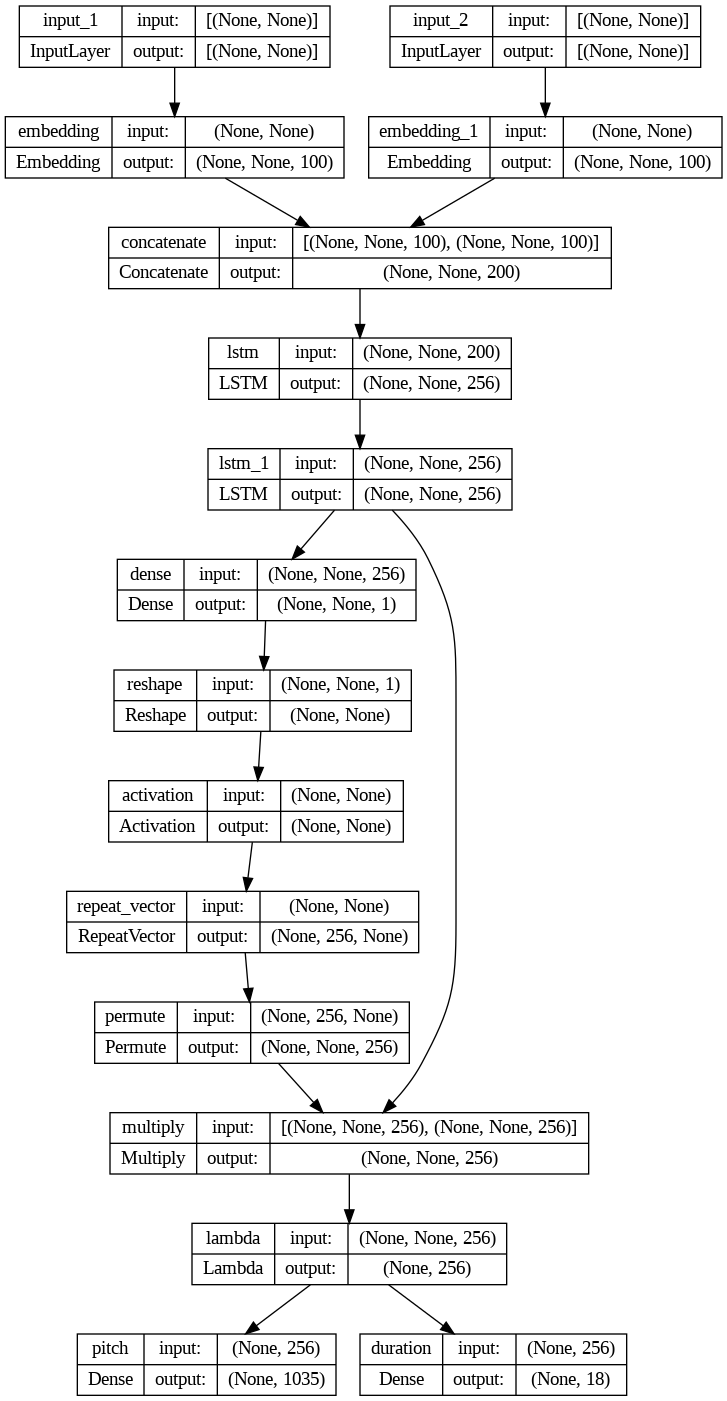

In [36]:
plot_model(model_lstm, show_shapes = True, show_layer_names = True)

In [37]:
checkpoint = ModelCheckpoint(
    "weights_lstm.h5",
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint
    , early_stopping
 ]


history_lstm = model_lstm.fit(network_input, network_output
          , epochs=40, batch_size=128
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/40
196/196 [==============================] - 189s 927ms/step - loss: 7.3216 - pitch_loss: 6.3258 - duration_loss: 0.9958 - pitch_Accuracy: 0.0328 - pitch_precision: 0.8889 - pitch_recall: 0.0042 - duration_Accuracy: 0.7192 - duration_precision_1: 0.7954 - duration_recall_1: 0.6474 - val_loss: 7.4517 - val_pitch_loss: 6.7420 - val_duration_loss: 0.7097 - val_pitch_Accuracy: 0.0240 - val_pitch_precision: 1.0000 - val_pitch_recall: 0.0125 - val_duration_Accuracy: 0.8375 - val_duration_precision_1: 0.8860 - val_duration_recall_1: 0.7920
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 176s 897ms/step - loss: 6.6938 - pitch_loss: 5.9547 - duration_loss: 0.7391 - pitch_Accuracy: 0.0472 - pitch_precision: 0.9597 - pitch_recall: 0.0228 - duration_Accuracy: 0.7677 - duration_precision_1: 0.8409 - duration_recall_1: 0.7068 - val_loss: 7.3208 - val_pitch_loss: 6.6900 - val_duration_loss: 0.6308 - val_pitch_Accuracy: 0.0259 - val_pitch_precision: 0.9600 - val_pitch_recall: 0.0153 - val_duration_Accuracy: 0.8356 - val_duration_precision_1: 0.8836 - val_duration_recall_1: 0.8104
Epoch 3/40
196/196 [==============================] - 172s 880ms/step - loss: 6.3051 - pitch_loss: 5.6243 - duration_loss: 0.6807 - pitch_Accuracy: 0.0618 - pitch_precision: 0.9773 - pitch_recall: 0.0258 - duration_Accuracy: 0.7806 - duration_precision_1: 0.8481 - duration_recall_1: 0.7235 - val_loss: 7.4660 - val_pitch_loss: 6.6873 - val_duration_loss: 0.7787 - val_pitch_Accuracy: 0.0272 - val_pitch_precision: 0.8091 - val_pitch_recall: 0.0142 - val_duration

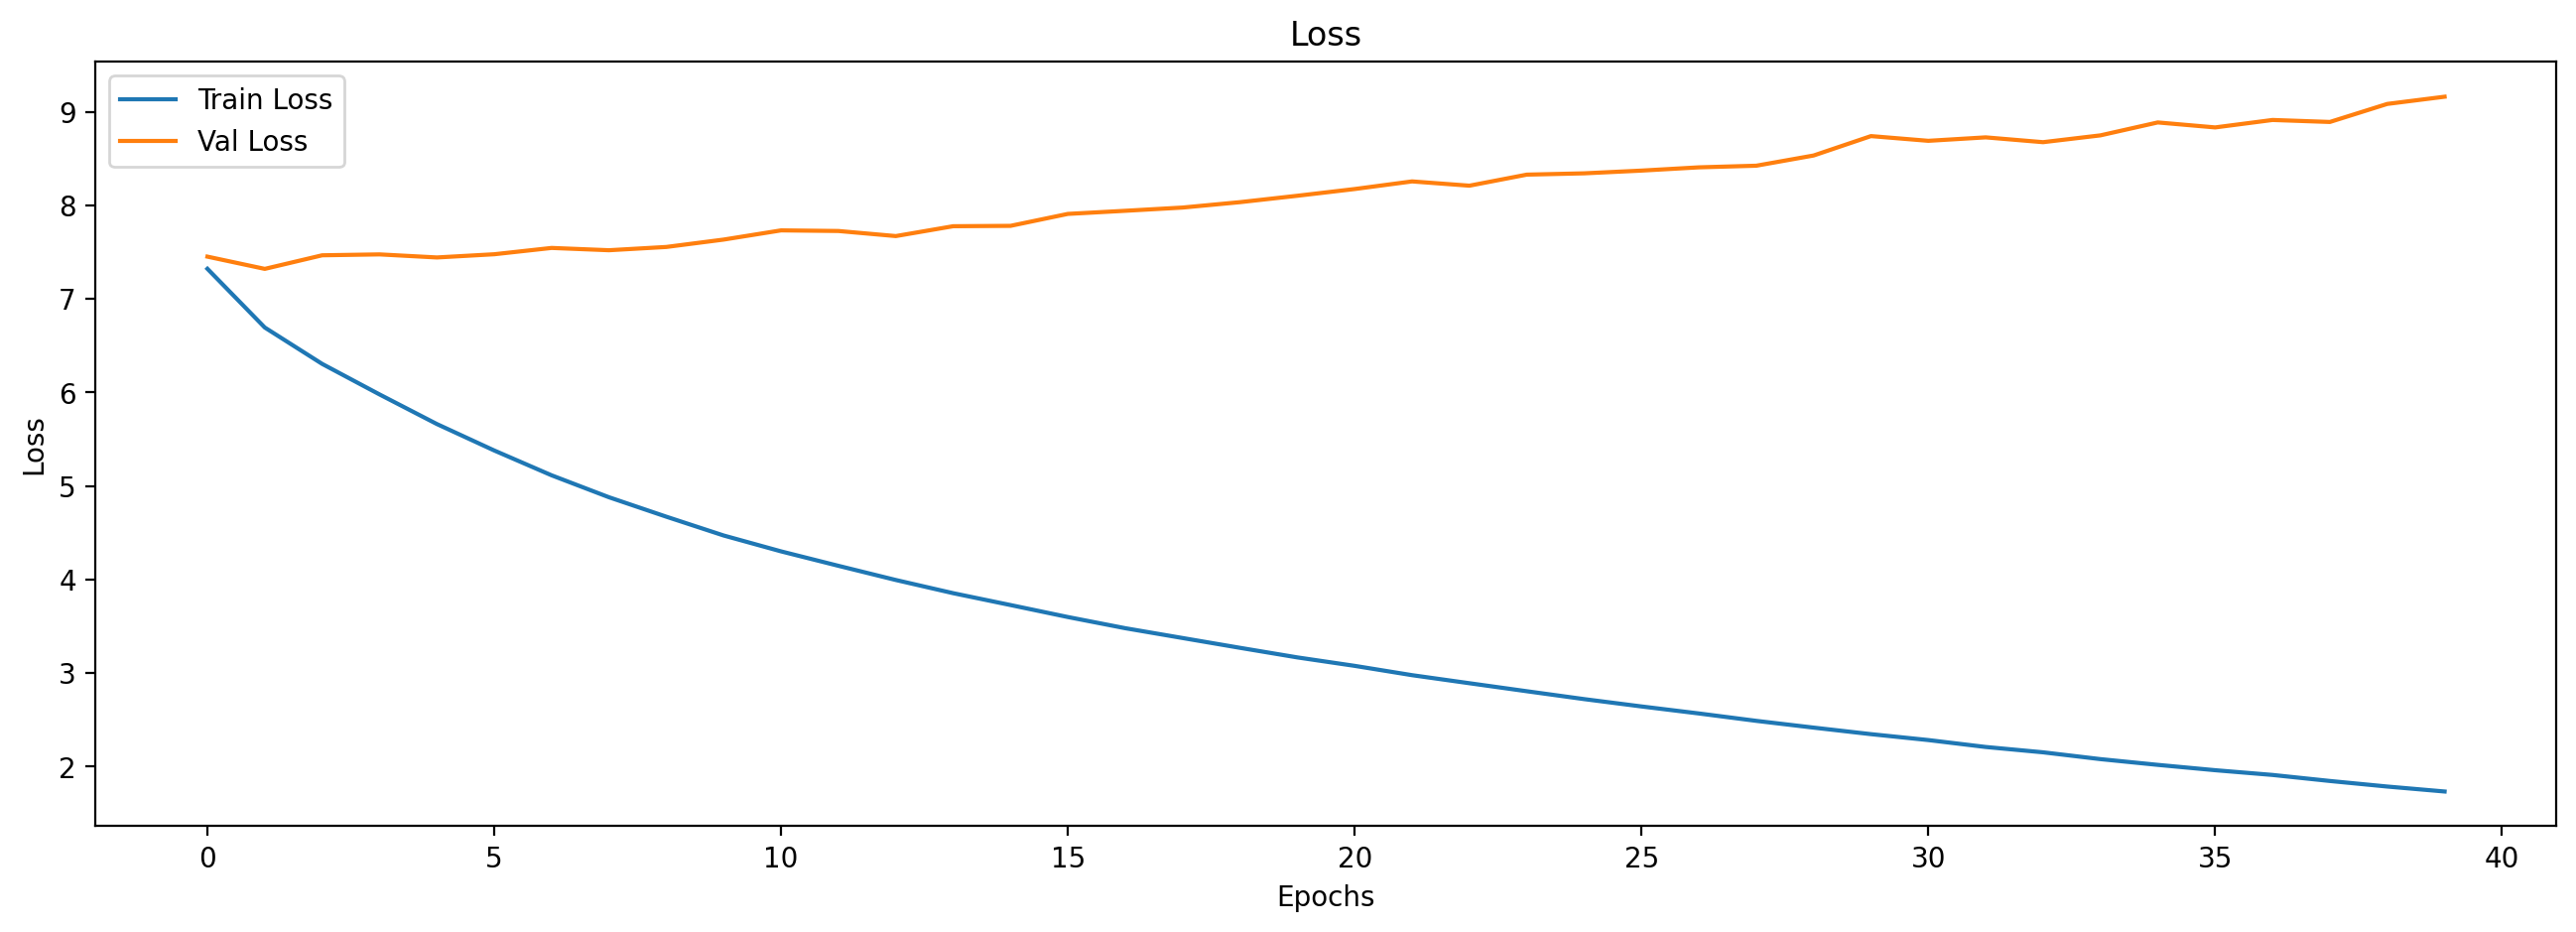

In [38]:
plt.figure(figsize = (16, 5))
plt.plot(history_lstm.history['loss'], label = 'Train Loss')
plt.plot(history_lstm.history['val_loss'], label = 'Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

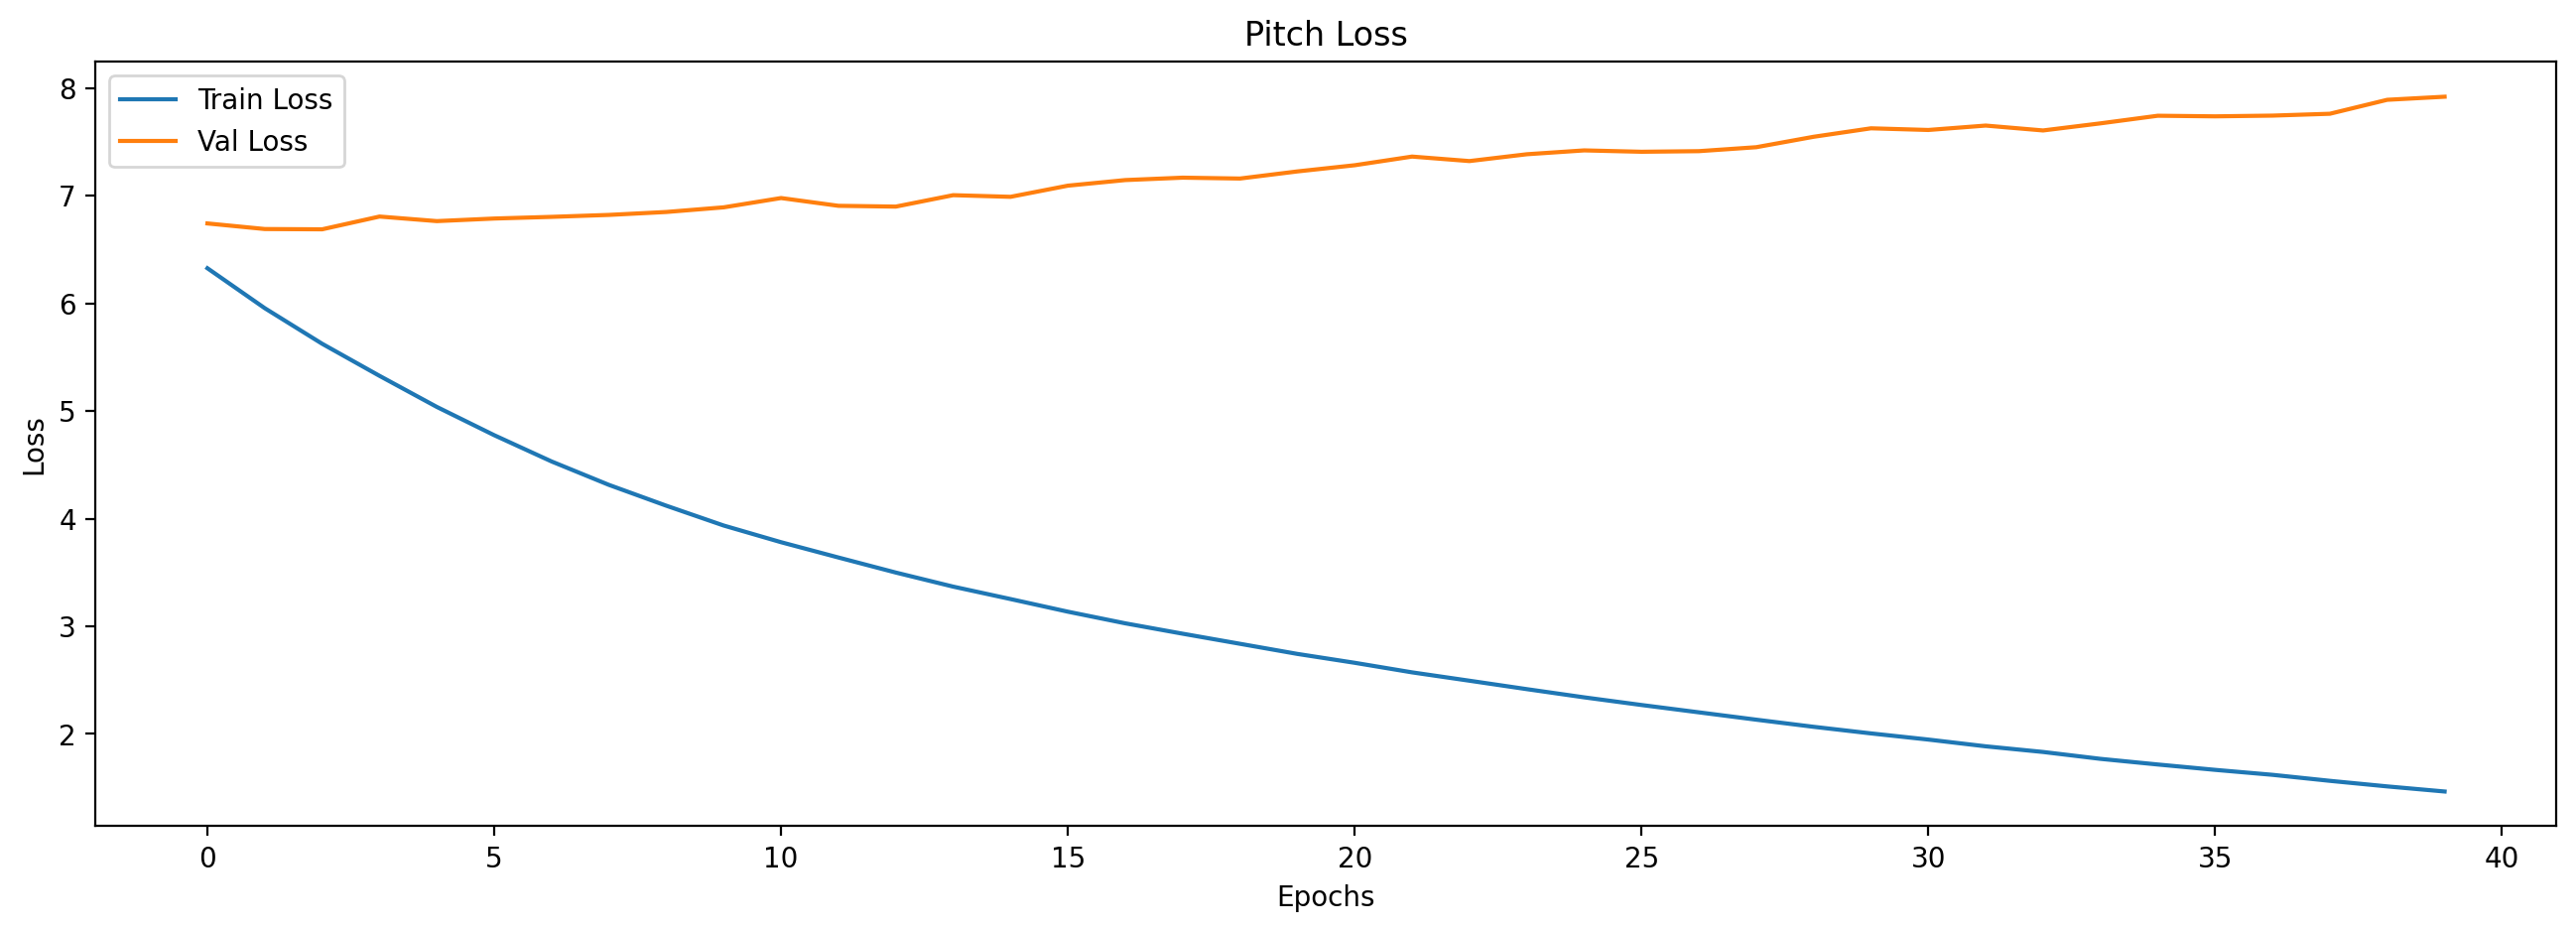

In [39]:
plt.figure(figsize = (16, 5))
plt.plot(history_lstm.history['pitch_loss'], label = 'Train Loss')
plt.plot(history_lstm.history['val_pitch_loss'], label = 'Val Loss')
plt.title('Pitch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

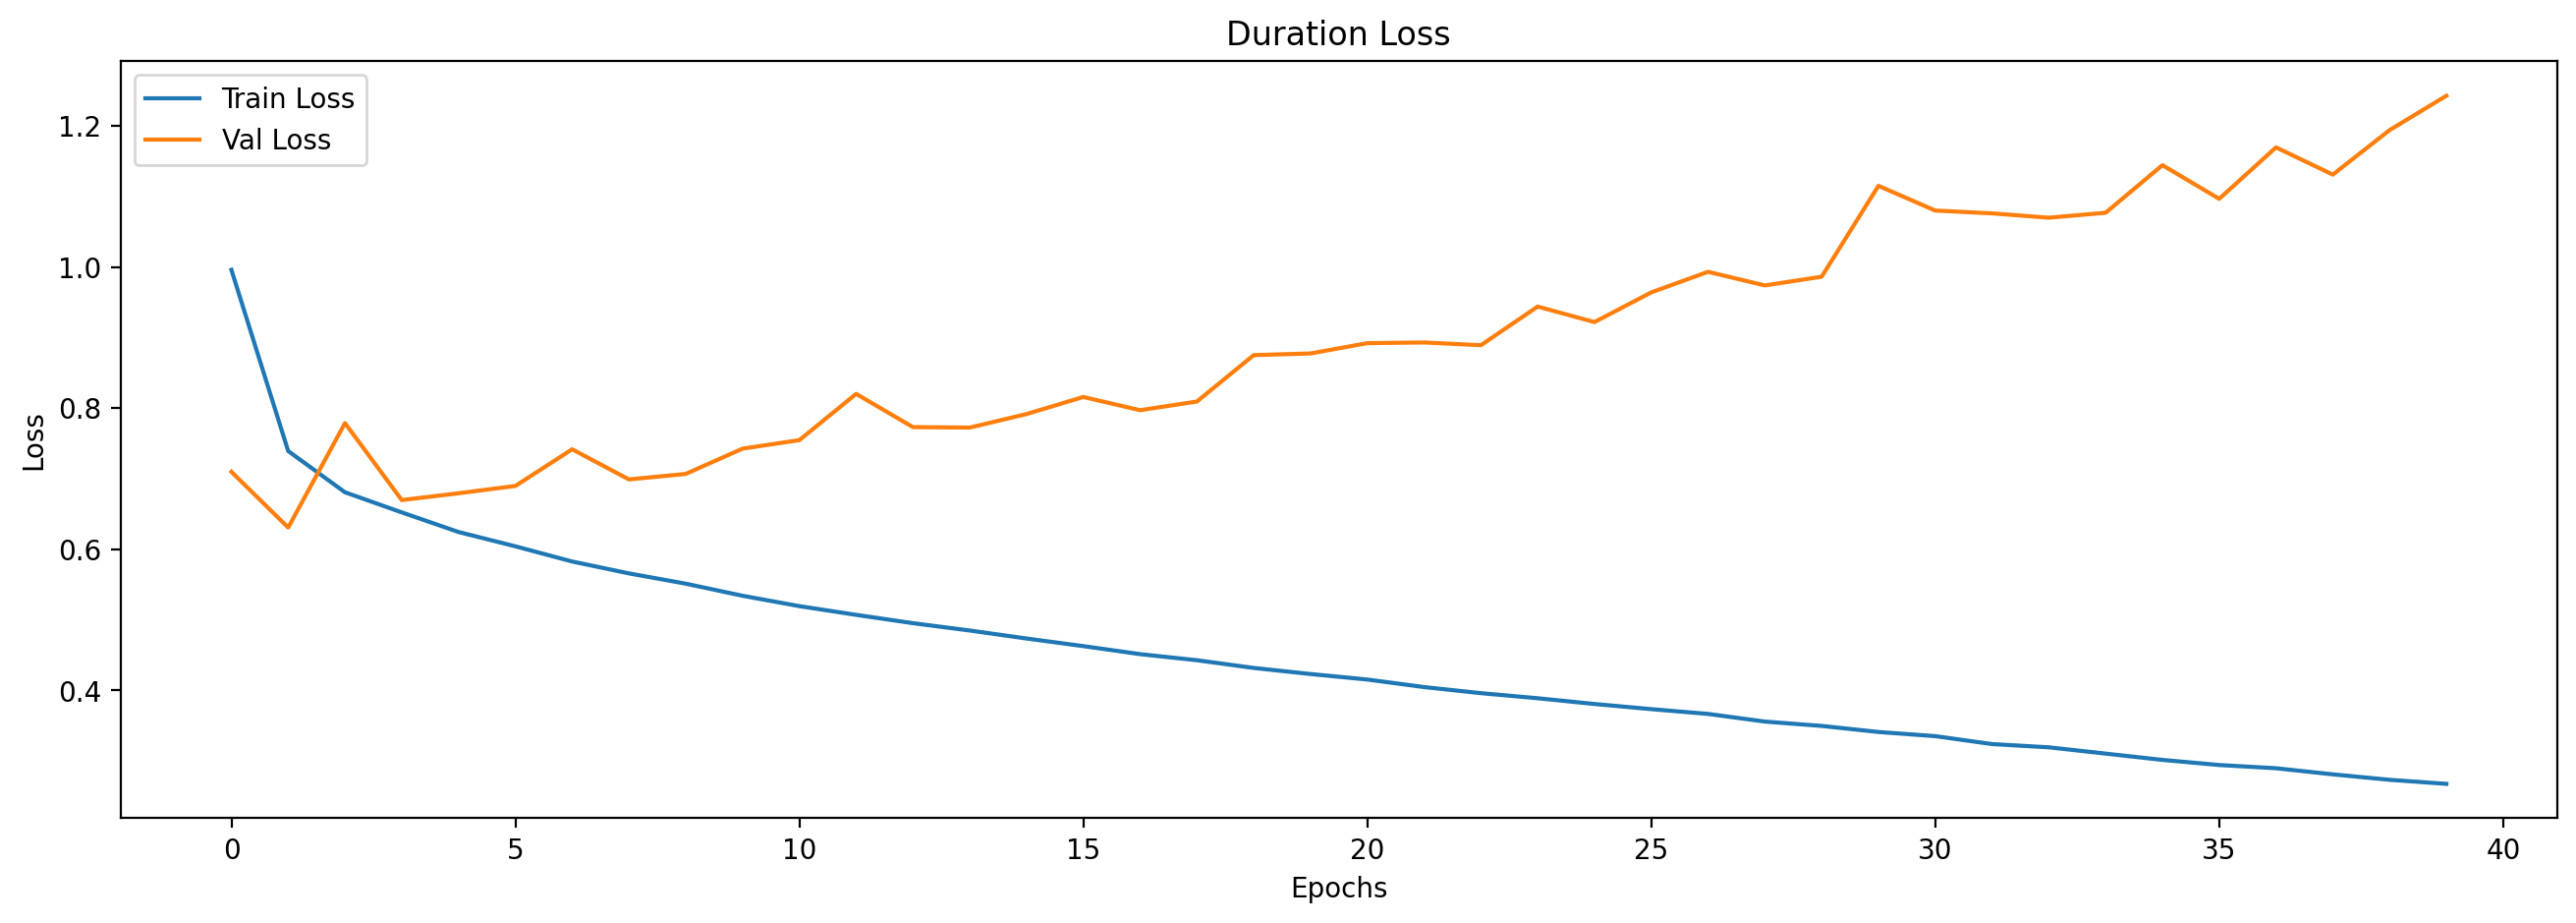

In [40]:
plt.figure(figsize = (16, 5))
plt.plot(history_lstm.history['duration_loss'], label = 'Train Loss')
plt.plot(history_lstm.history['val_duration_loss'], label = 'Val Loss')
plt.title('Duration Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

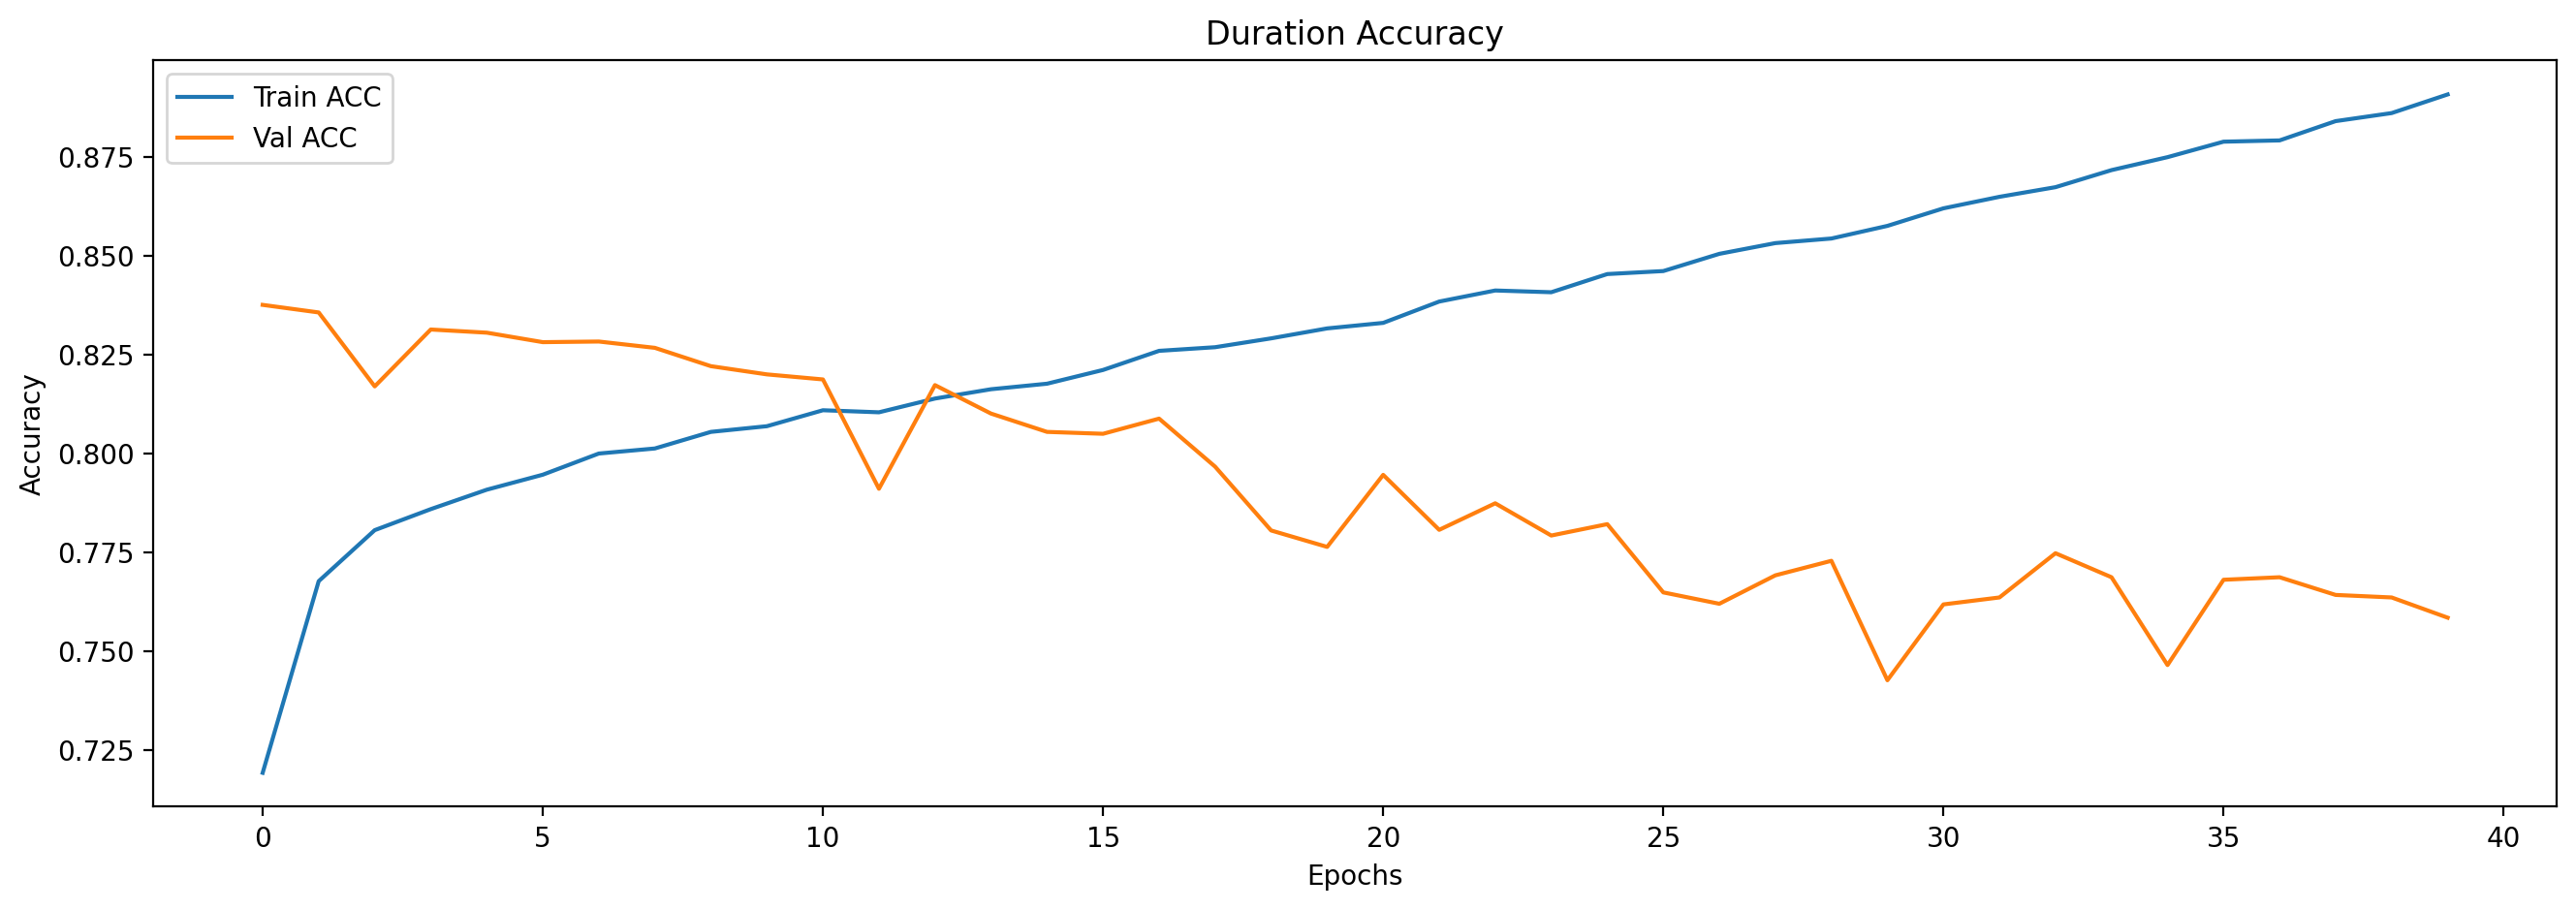

In [41]:
plt.figure(figsize = (16, 5))
plt.plot(history_lstm.history['duration_Accuracy'], label = 'Train ACC')
plt.plot(history_lstm.history['val_duration_Accuracy'], label = 'Val ACC')
plt.title('Duration Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

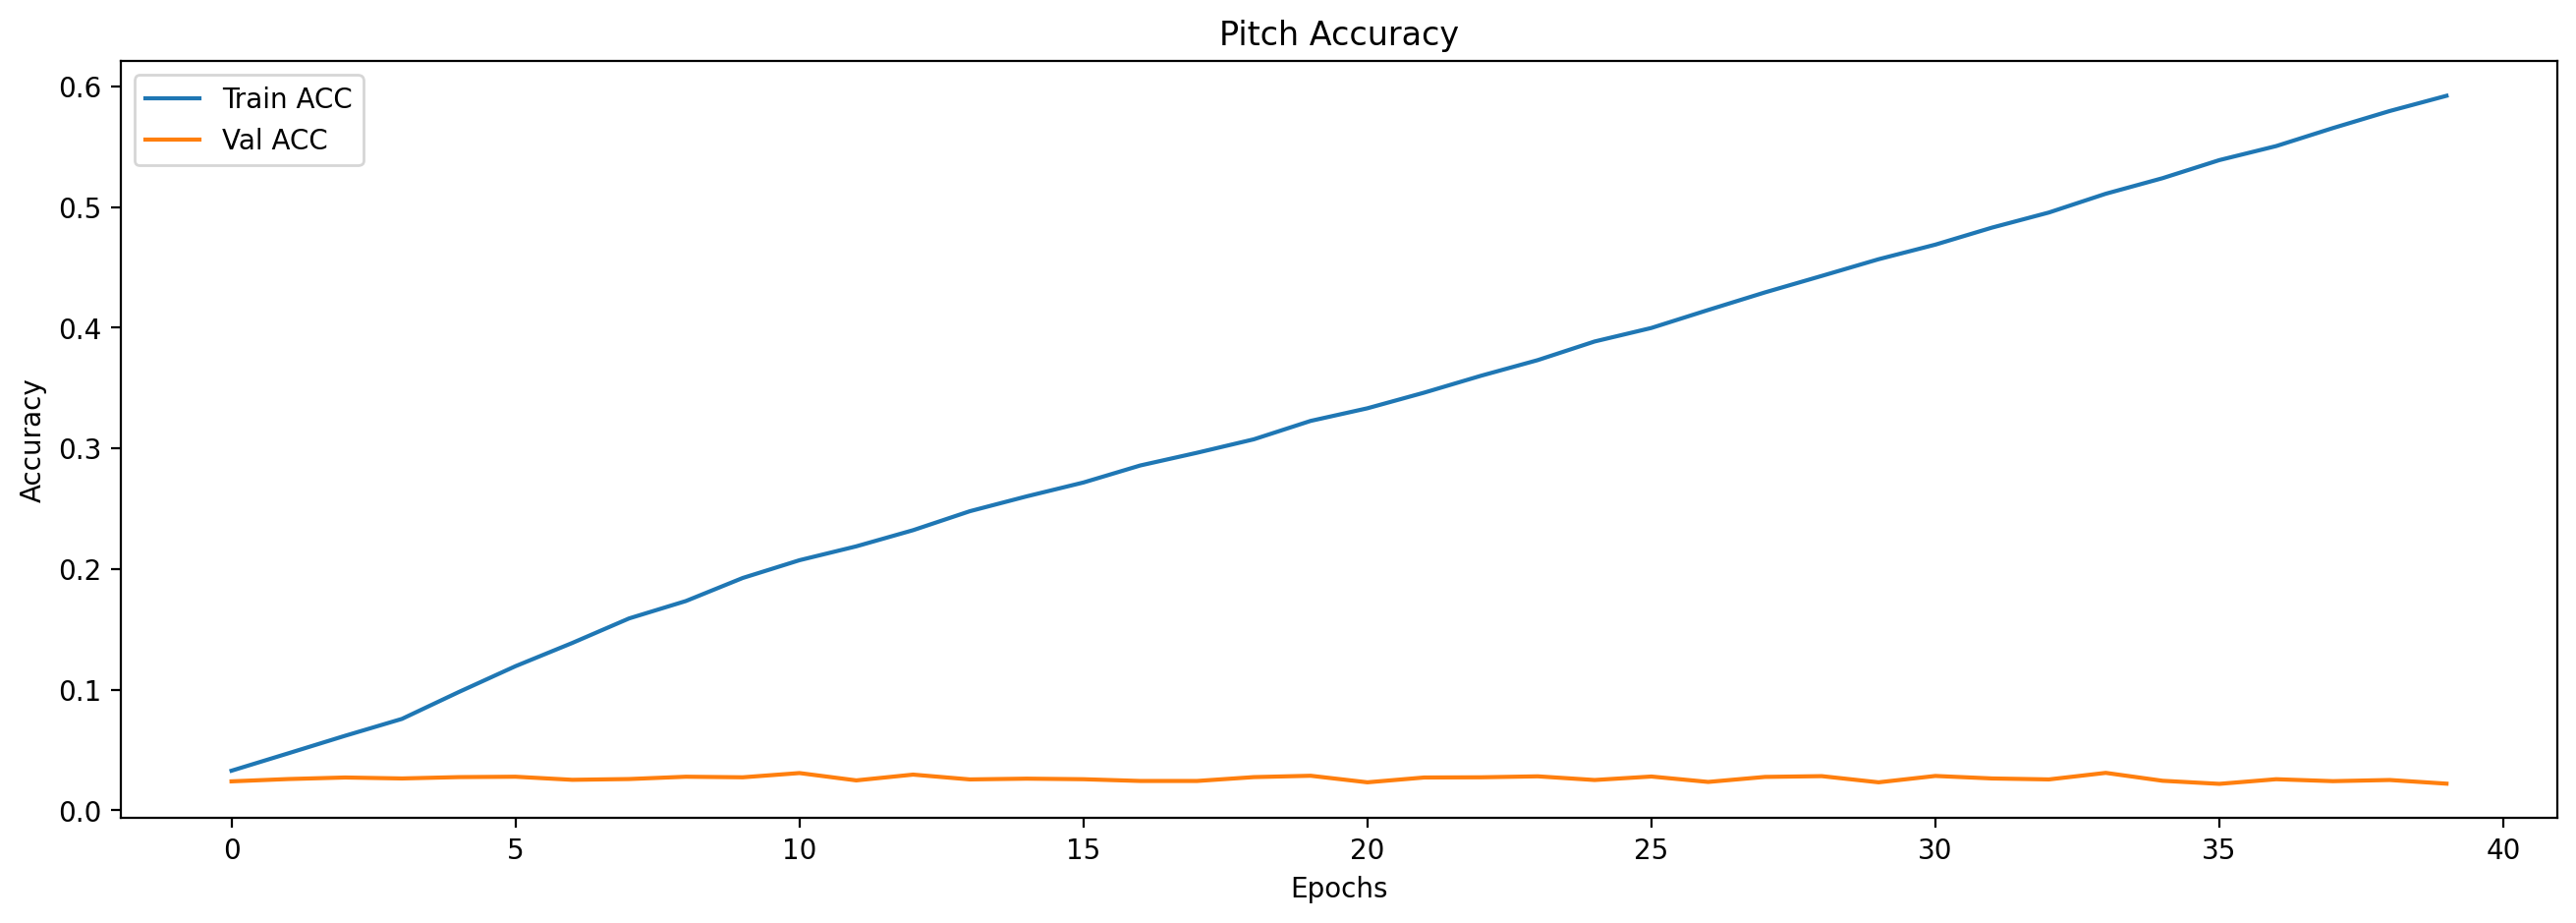

In [42]:
plt.figure(figsize = (16, 5))
plt.plot(history_lstm.history['pitch_Accuracy'], label = 'Train ACC')
plt.plot(history_lstm.history['val_pitch_Accuracy'], label = 'Val ACC')
plt.title('Pitch Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## GRU

In [43]:
model_gru, att_model_gru = create_network_gru(n_notes, n_durations, embed_size, rnn_units, use_attention)
model_gru.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 100)            103500    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, None, 100)            1800      ['input_4[0][0]']             
                                                                                            

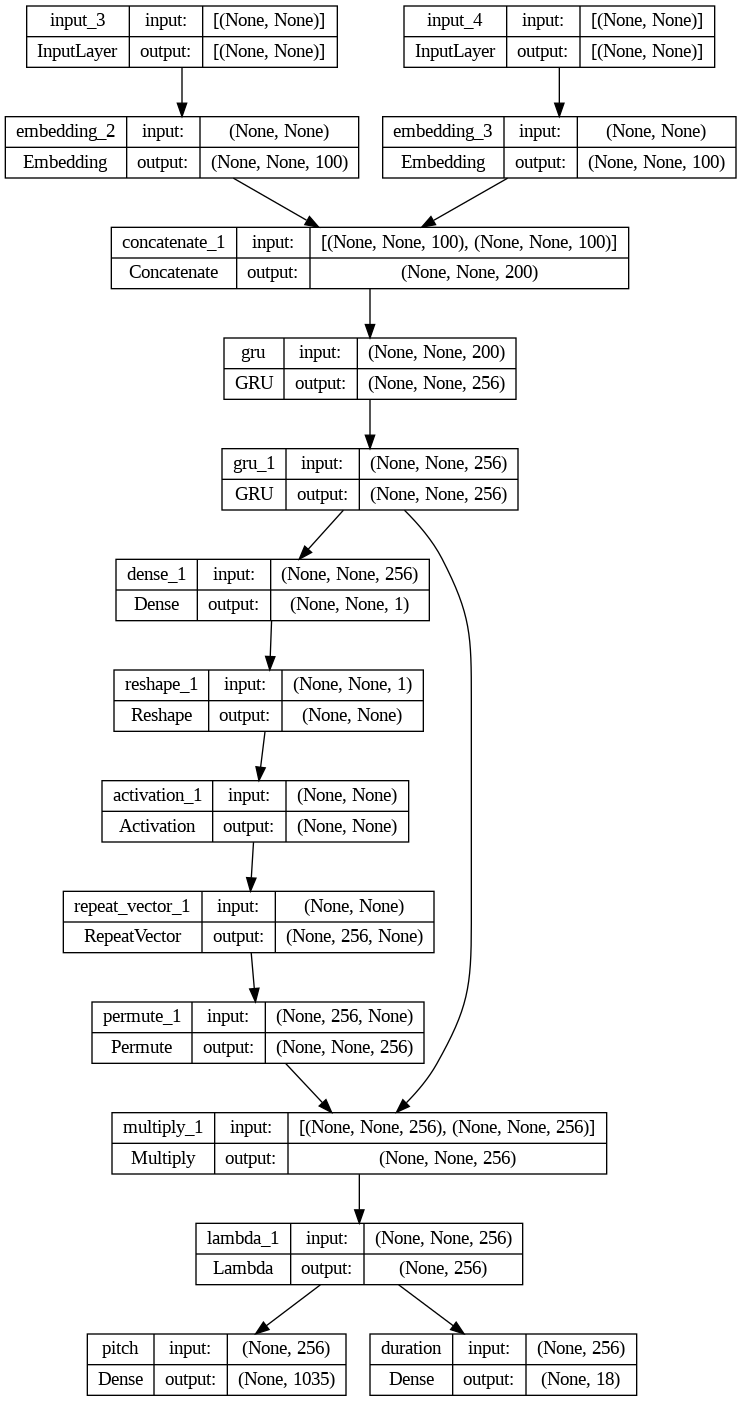

In [44]:
plot_model(model_gru, show_shapes = True, show_layer_names = True)

In [45]:
checkpoint = ModelCheckpoint(
    "weights_gru.h5",
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint
    , early_stopping
 ]


history_gru = model_gru.fit(network_input, network_output
          , epochs=40, batch_size=128
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/40
196/196 [==============================] - 135s 656ms/step - loss: 7.1581 - pitch_loss: 6.2541 - duration_loss: 0.9041 - pitch_Accuracy: 0.0364 - pitch_precision: 0.6621 - pitch_recall: 0.0096 - duration_Accuracy: 0.7345 - duration_precision_1: 0.8166 - duration_recall_1: 0.6575 - val_loss: 7.2516 - val_pitch_loss: 6.6816 - val_duration_loss: 0.5700 - val_pitch_Accuracy: 0.0323 - val_pitch_precision: 0.7870 - val_pitch_recall: 0.0136 - val_duration_Accuracy: 0.8476 - val_duration_precision_1: 0.8941 - val_duration_recall_1: 0.8147
Epoch 2/40
196/196 [==============================] - 137s 700ms/step - loss: 6.4304 - pitch_loss: 5.7324 - duration_loss: 0.6981 - pitch_Accuracy: 0.0575 - pitch_precision: 0.9049 - pitch_recall: 0.0251 - duration_Accuracy: 0.7775 - duration_precision_1: 0.8482 - duration_recall_1: 0.7182 - val_loss: 7.2425 - val_pitch_loss: 6.6447 - val_duration_loss: 0.5978 - val_pitch_Accuracy: 0.0289 - val_pitch_precision: 0.8957 - val_pitch_recall: 0.0165 - v

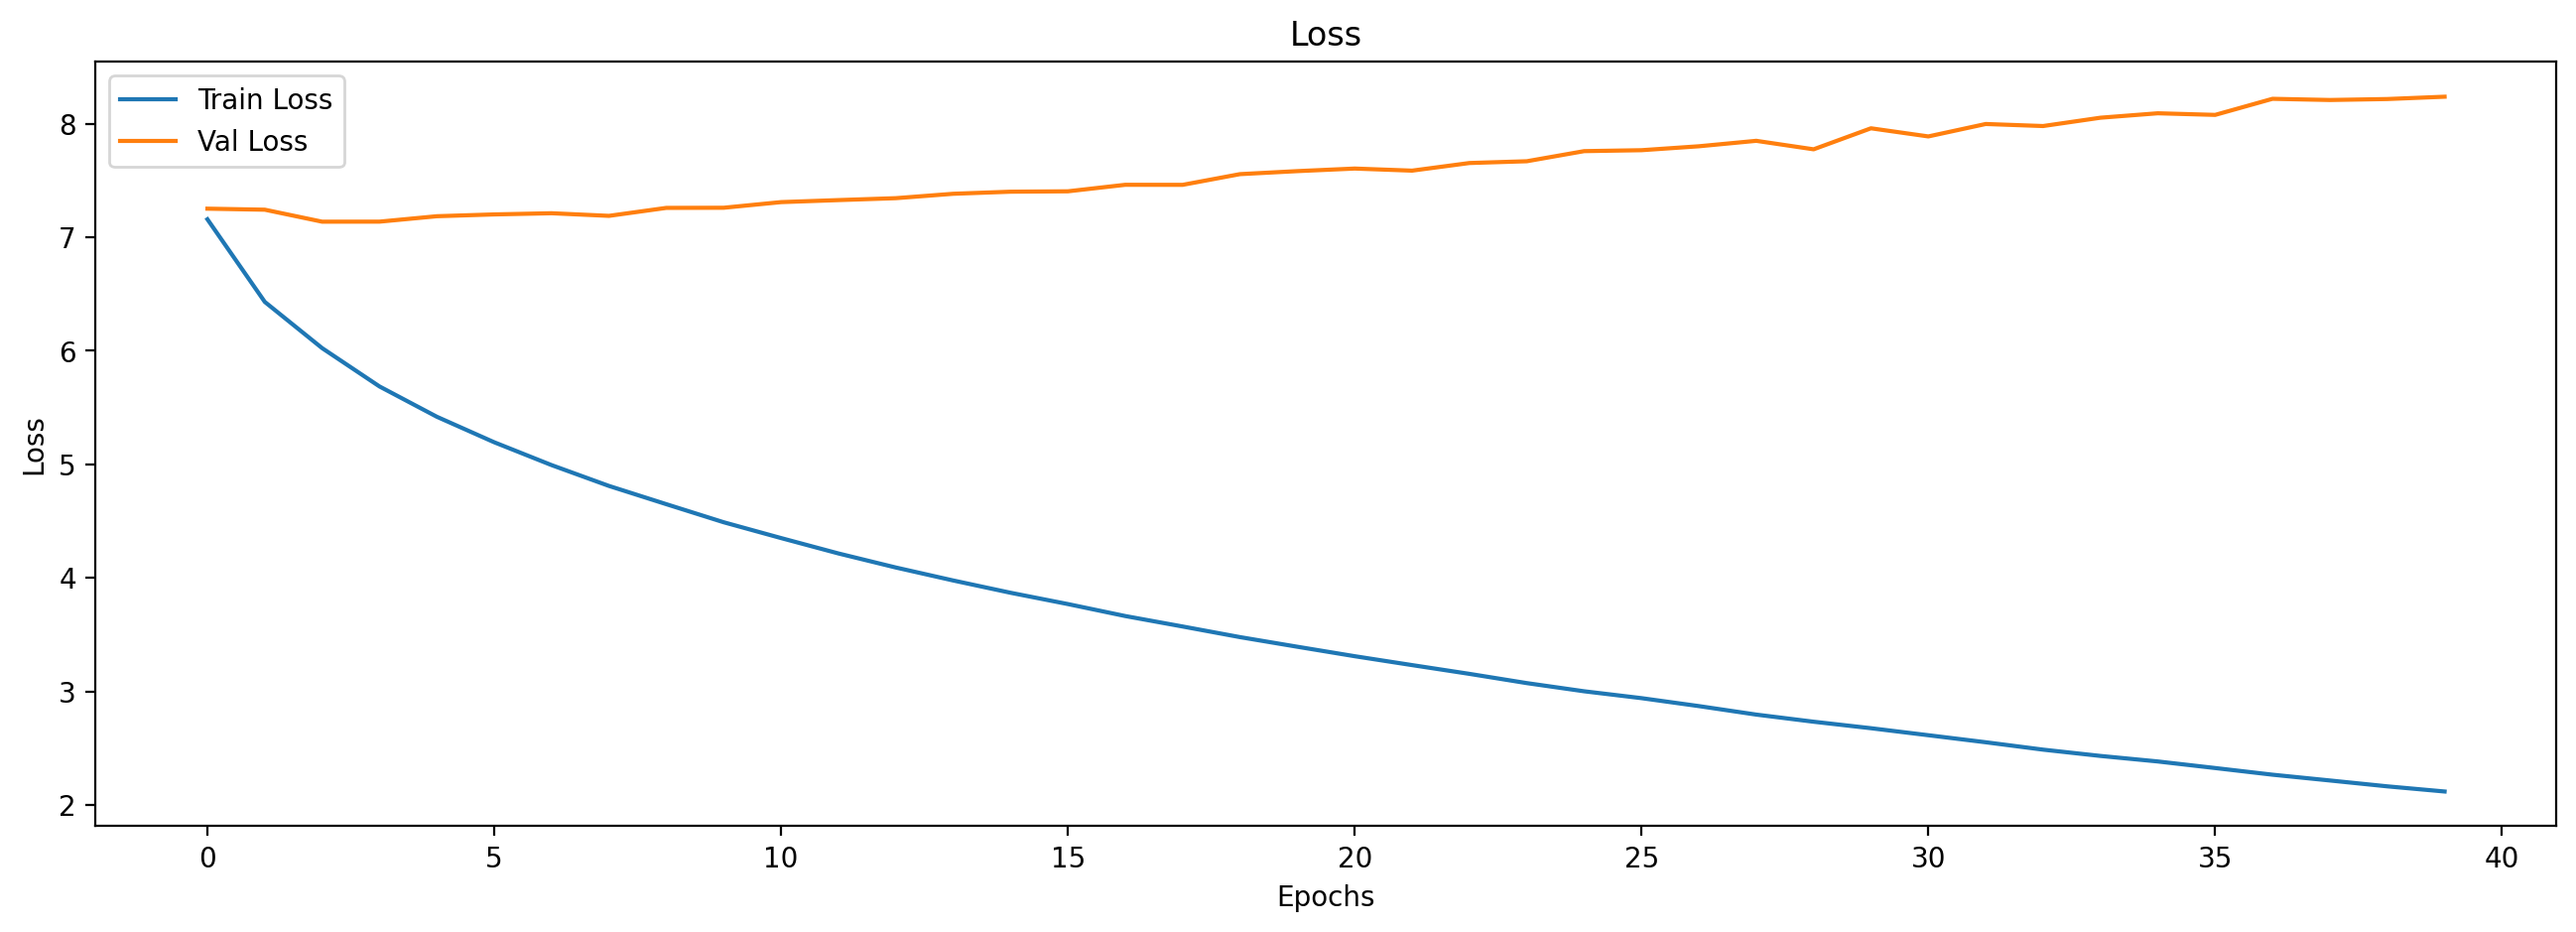

In [46]:
plt.figure(figsize = (16, 5))
plt.plot(history_gru.history['loss'], label = 'Train Loss')
plt.plot(history_gru.history['val_loss'], label = 'Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

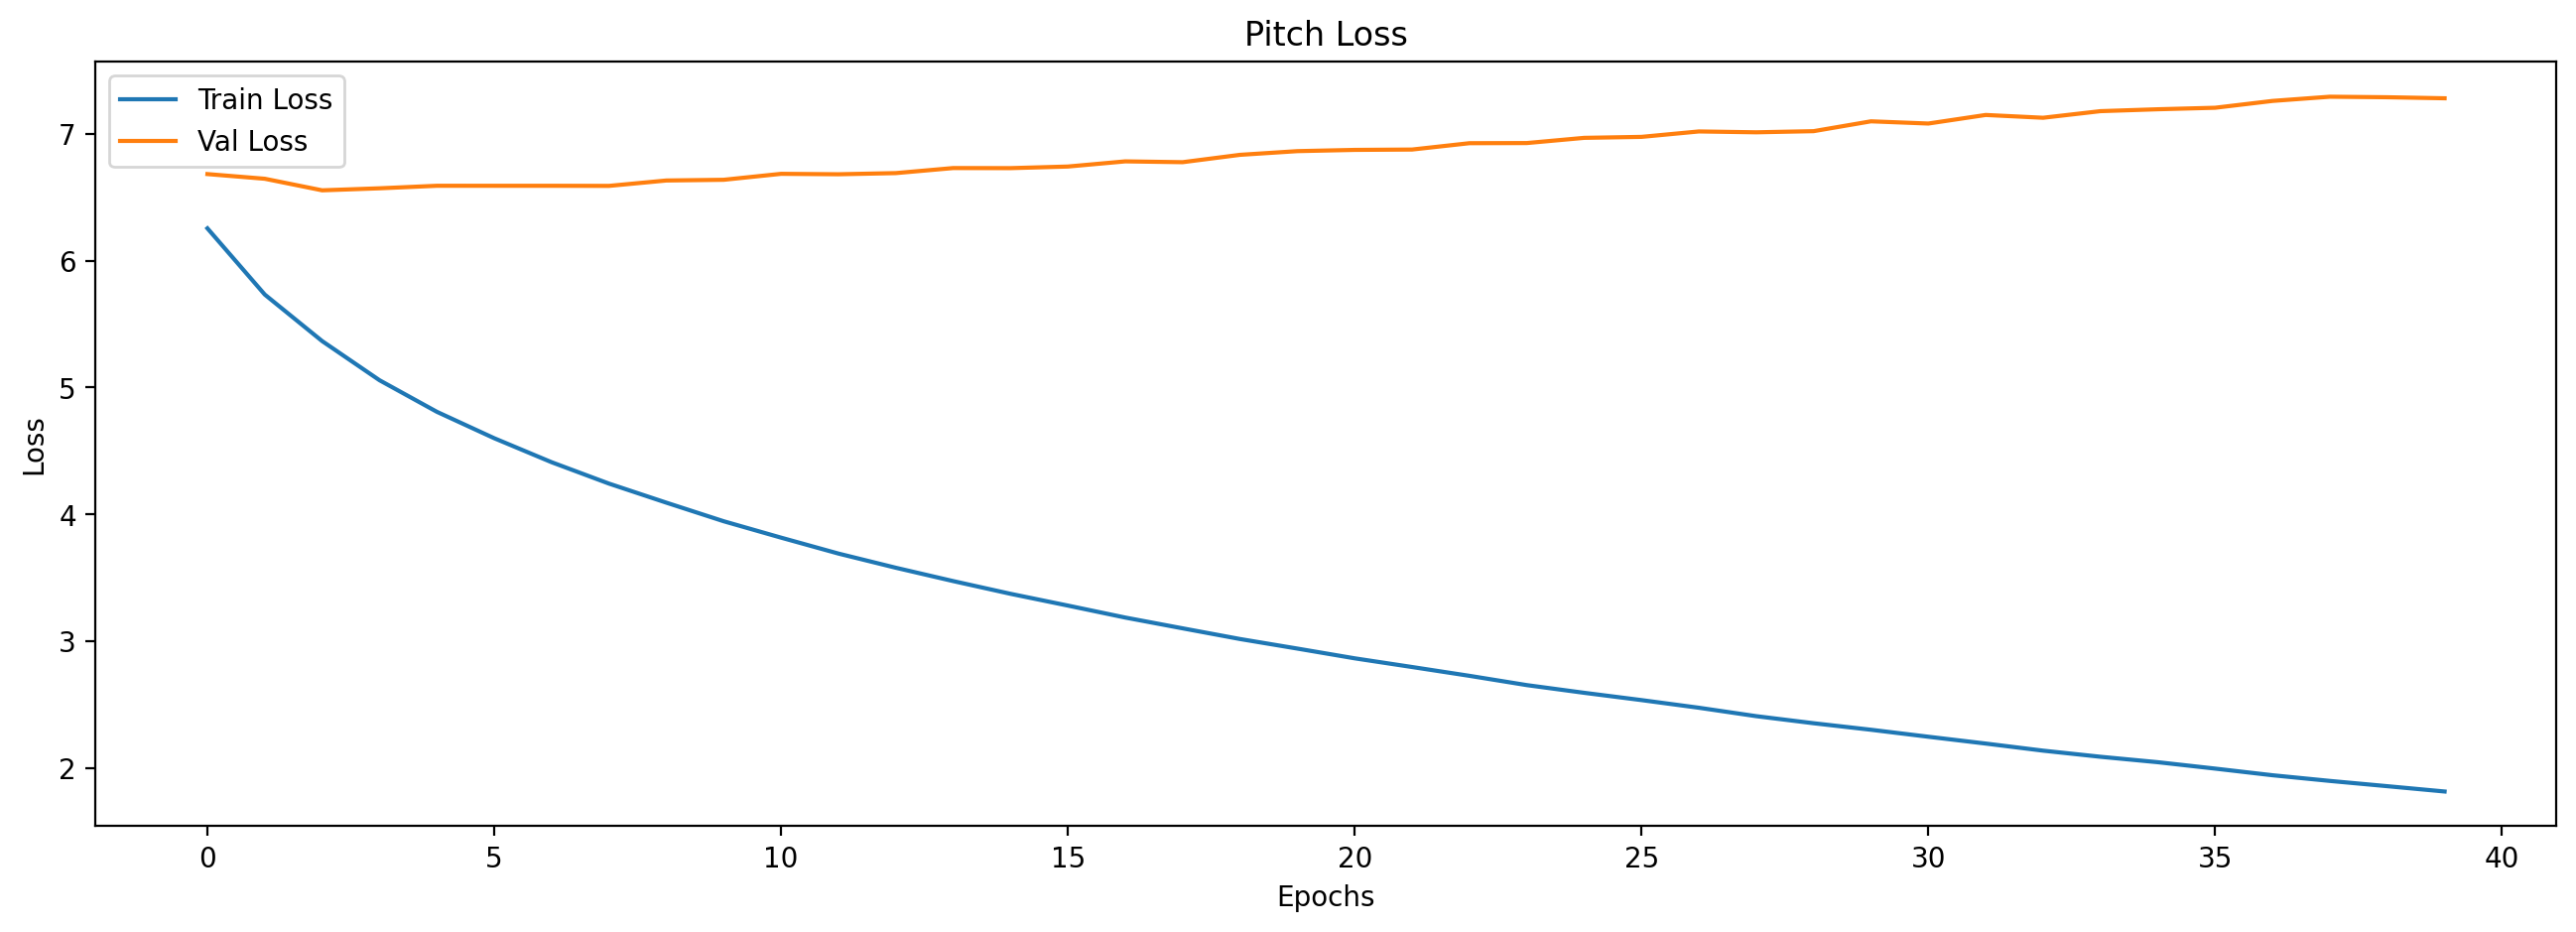

In [47]:
plt.figure(figsize = (16, 5))
plt.plot(history_gru.history['pitch_loss'], label = 'Train Loss')
plt.plot(history_gru.history['val_pitch_loss'], label = 'Val Loss')
plt.title('Pitch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

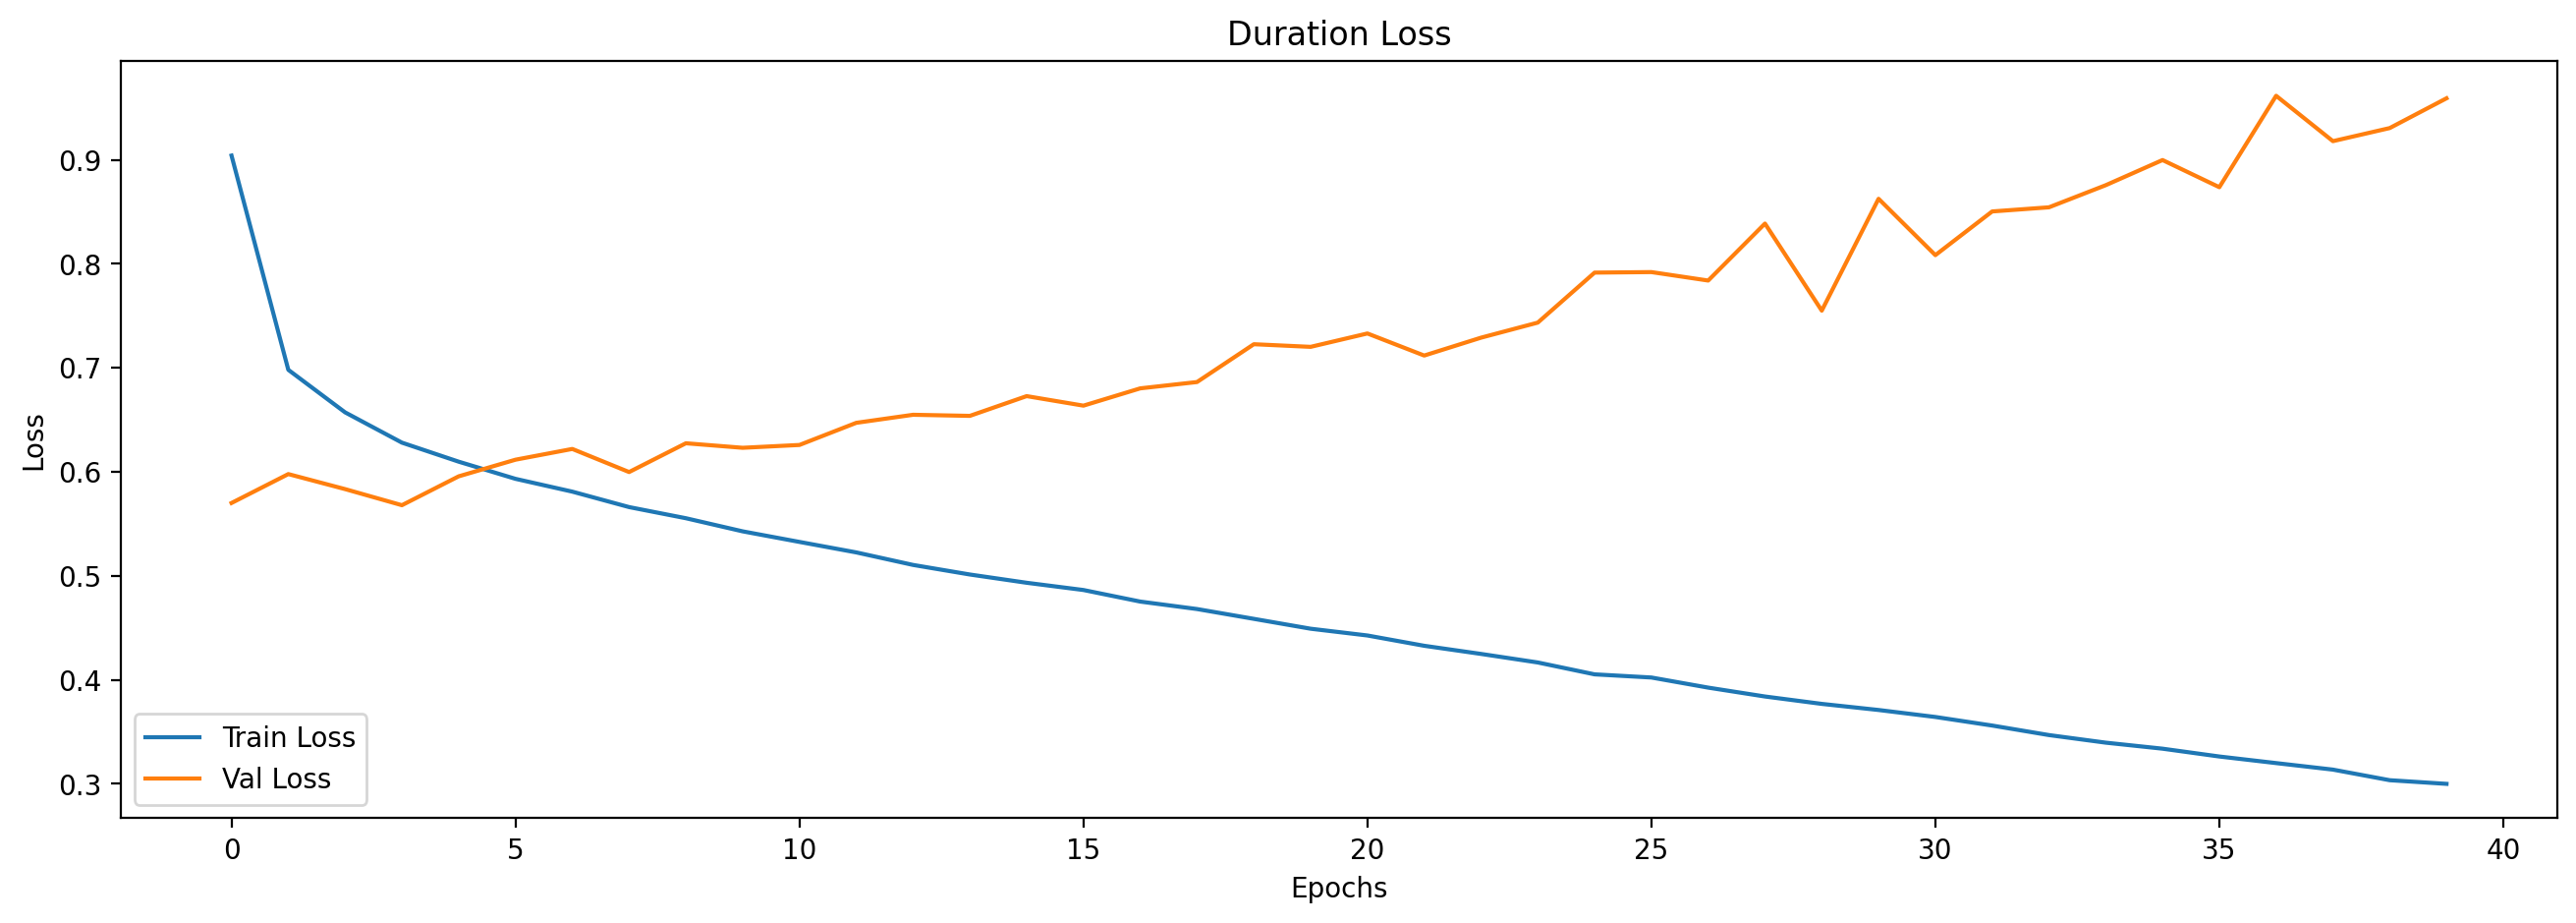

In [48]:
plt.figure(figsize = (16, 5))
plt.plot(history_gru.history['duration_loss'], label = 'Train Loss')
plt.plot(history_gru.history['val_duration_loss'], label = 'Val Loss')
plt.title('Duration Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

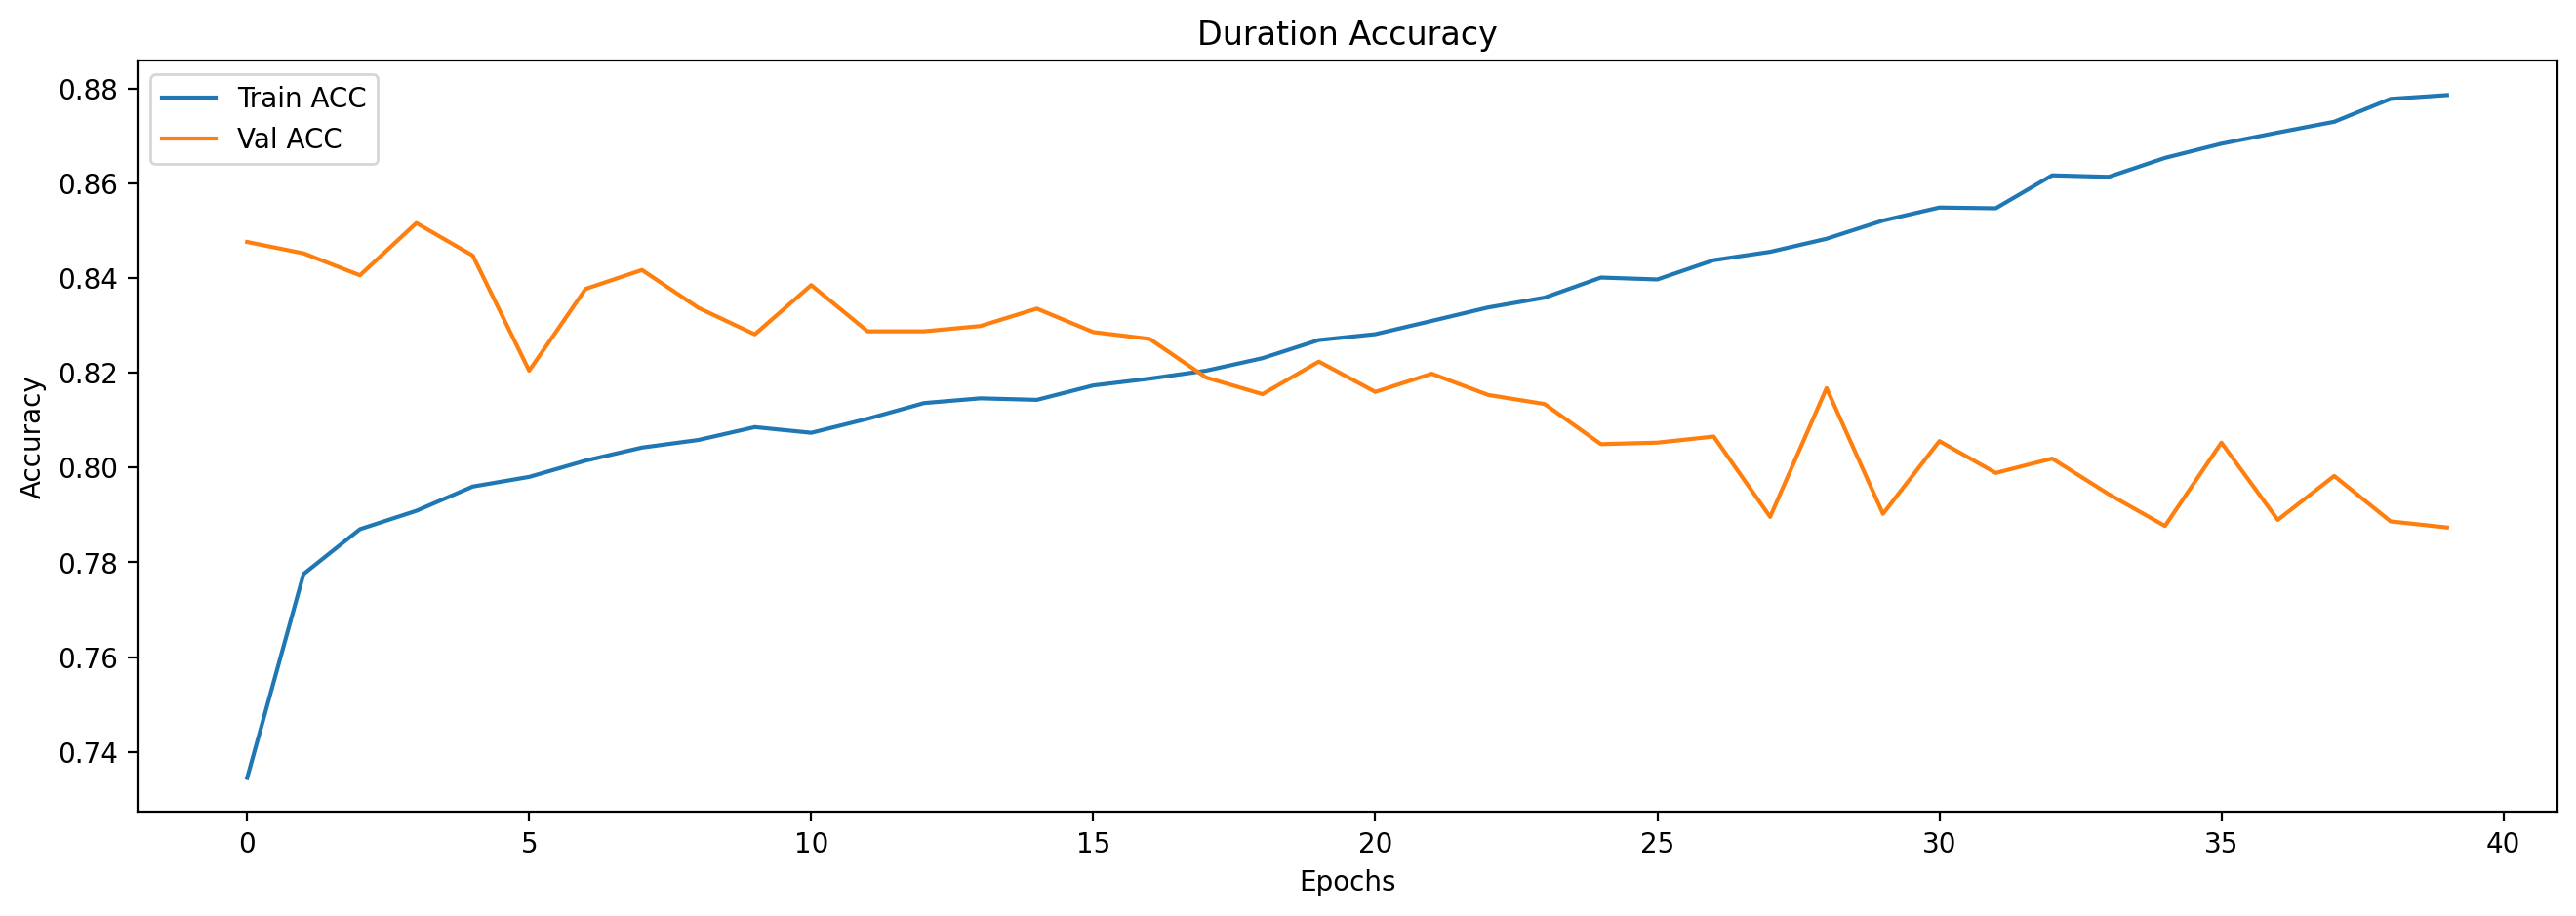

In [49]:
plt.figure(figsize = (16, 5))
plt.plot(history_gru.history['duration_Accuracy'], label = 'Train ACC')
plt.plot(history_gru.history['val_duration_Accuracy'], label = 'Val ACC')
plt.title('Duration Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

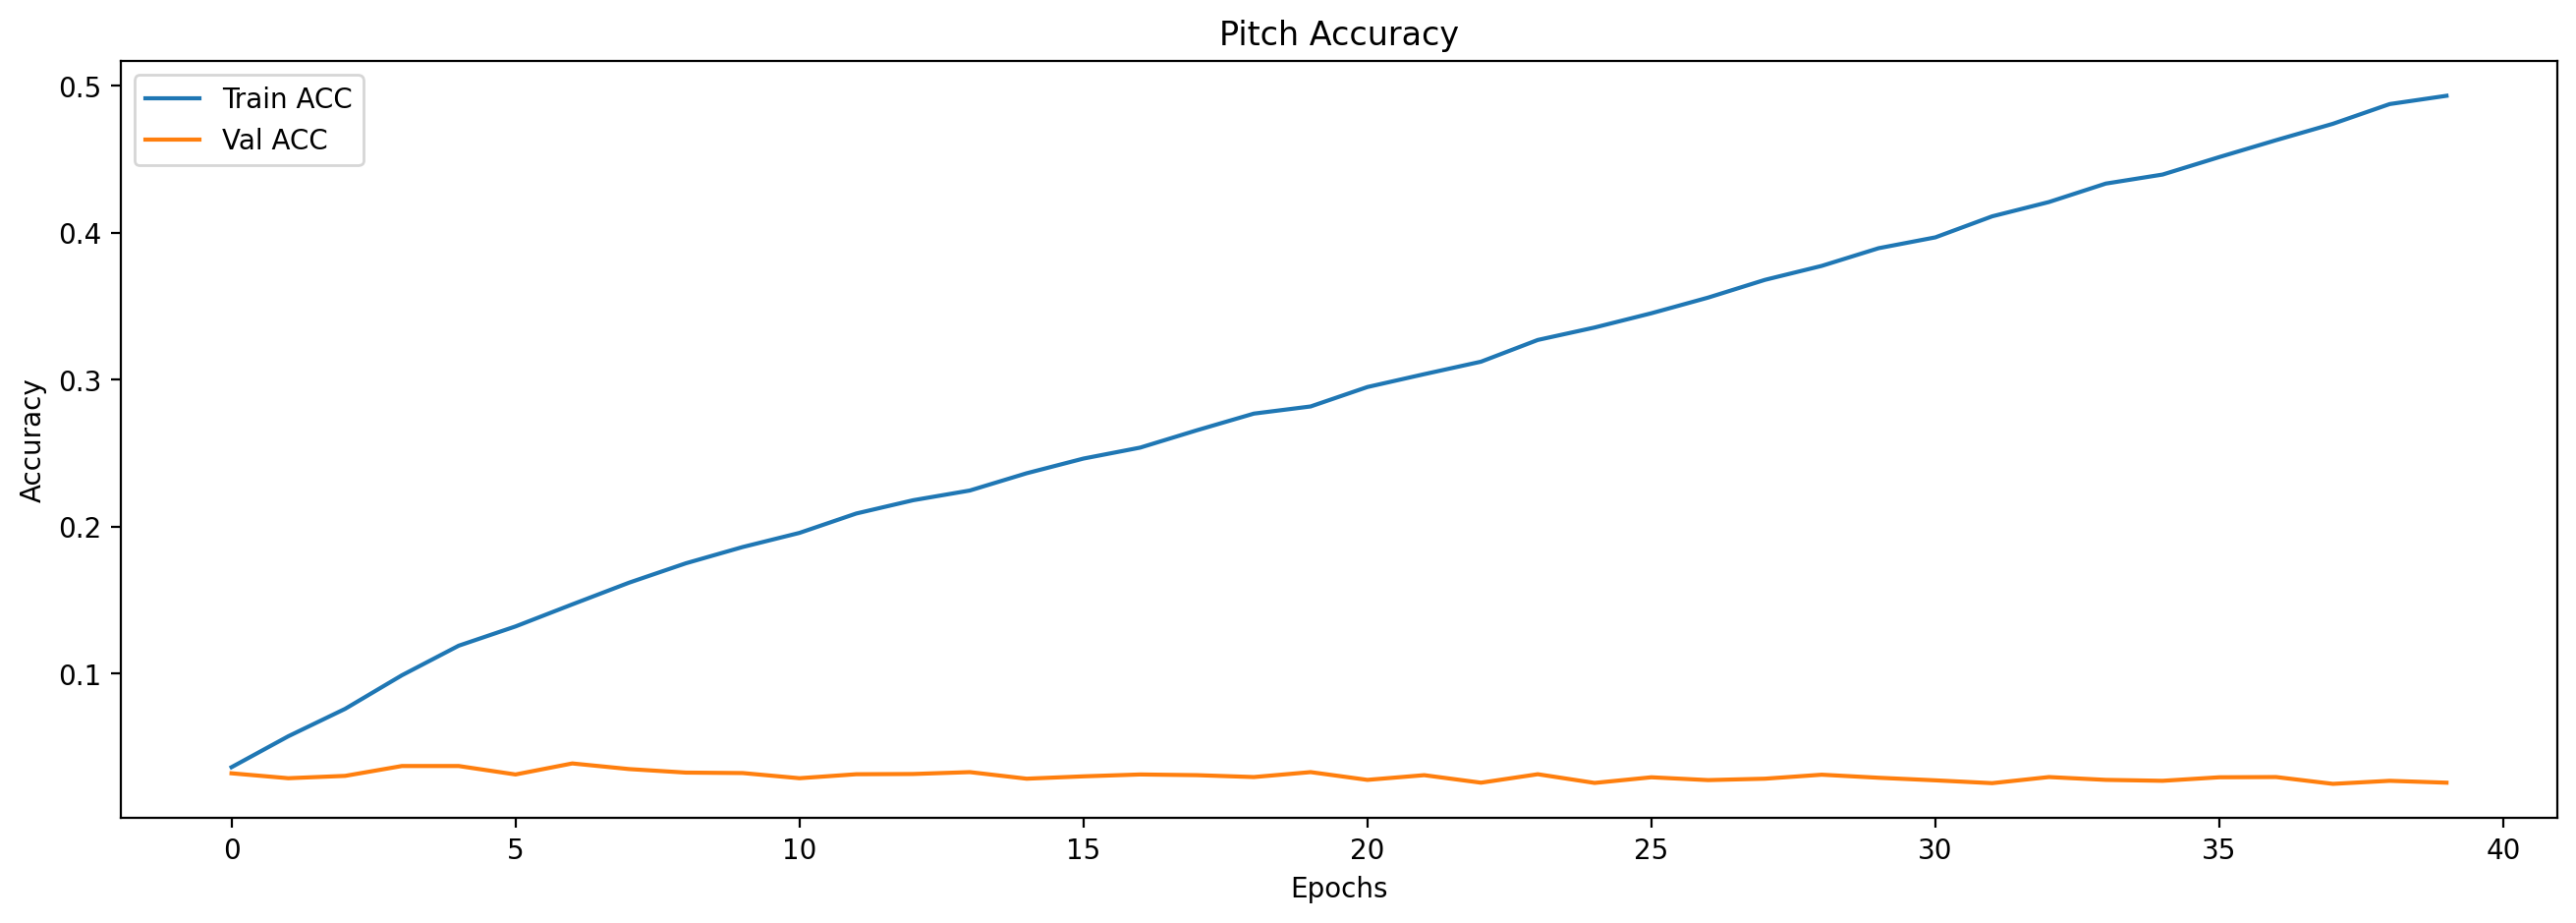

In [50]:
plt.figure(figsize = (16, 5))
plt.plot(history_gru.history['pitch_Accuracy'], label = 'Train ACC')
plt.plot(history_gru.history['val_pitch_Accuracy'], label = 'Val ACC')
plt.title('Pitch Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

----------------------------------------
# Predicting

## LSTM

In [51]:
# prediction params
notes_temp=0.5
duration_temp = 0.5
max_extra_notes = 400
max_seq_len = 32
seq_len = 32

notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + durations

sequence_length = len(notes)

In [52]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []
overall_preds = []

for n, d in zip(notes,durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]

    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)

    prediction_output.append([n, d])

    if n != 'START':
        midi_note = note.Note(n)
        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)

att_matrix = np.zeros(shape = (max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):

    prediction_input = [
        np.array([notes_input_sequence])
        , np.array([durations_input_sequence])
       ]

    notes_prediction, durations_prediction = model_lstm.predict(prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model_lstm.predict(prediction_input, verbose=0)[0]
        att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction

    new_note = np.zeros(128)

    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
        except:
            pass

    overall_preds.append(new_note)

    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]

    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)

    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]

    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds))
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 432 notes


In [53]:
midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)

midi_stream = midi_stream.chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
new_file = 'music_generated_lstm.mid'
midi_stream.write('midi', 'music_generated_lstm.mid')

'music_generated_lstm.mid'

In [54]:
fs = FluidSynth()
fs.midi_to_audio('music_generated_lstm.mid', 'new_output_lstm.wav')

In [55]:
new_score = converter.parse('music_generated_lstm.mid').chordify()

In [56]:
IPython.display.Audio("new_output_lstm.wav")

Output hidden; open in https://colab.research.google.com to view.

In [57]:
new_score.show()

## GRU

In [58]:
# prediction params
notes_temp=0.5
duration_temp = 0.5
max_extra_notes = 400
max_seq_len = 32
seq_len = 32

notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + durations

sequence_length = len(notes)

In [59]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []
overall_preds = []

for n, d in zip(notes,durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]

    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)

    prediction_output.append([n, d])

    if n != 'START':
        midi_note = note.Note(n)
        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)

att_matrix = np.zeros(shape = (max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):

    prediction_input = [
        np.array([notes_input_sequence])
        , np.array([durations_input_sequence])
       ]

    notes_prediction, durations_prediction = model_gru.predict(prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model_gru.predict(prediction_input, verbose=0)[0]
        att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction

    new_note = np.zeros(128)

    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
        except:
            pass

    overall_preds.append(new_note)

    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]

    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)

    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]

    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds))
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 432 notes


In [60]:
midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)

midi_stream = midi_stream.chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
new_file = 'music_generated_gru.mid'
midi_stream.write('midi', 'music_generated_gru.mid')

'music_generated_gru.mid'

In [61]:
fs = FluidSynth()
fs.midi_to_audio('music_generated_gru.mid', 'new_output_gru.wav')

In [62]:
new_score = converter.parse('music_generated_gru.mid').chordify()

In [63]:
IPython.display.Audio("new_output_gru.wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
new_score.show()